In [ ]:
!pip3 -q install gym-super-mario-bros
!pip3 -q install matplotlib
!pip3 -q install torchviz

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# %cd /content/drive/My Drive/9223 Deep Learning

# !pwd

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
from matplotlib import rc
from collections import deque
from tqdm import tqdm
import collections

%matplotlib inline
rc('animation', html='html5')
# rc('animation', html='jshtml')

from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY
import gym

In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print ('Using GPU: ', torch.cuda.get_device_name( 0 ))
else:
  device = torch.device("cpu")
  print ('Using CPU')

Using GPU:  Tesla V100-SXM2-16GB


# Initialize Environment

In [ ]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [ ]:
action_space = env.get_action_meanings()
action_space

['NOOP', 'right', 'right A', 'right B', 'right A B', 'A', 'left']

In [ ]:
def display_frames(frames):
  """
  Displays a list of frames as a gif, with controls
  """
  patch = plt.imshow(frames[0])
  plt.axis('off')

  def animate(i):
    patch.set_data(frames[i])

  anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=20)
  
  return anim

## Test using a random agent

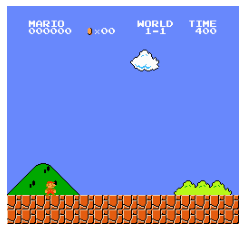

In [ ]:
observation = env.reset()
rewards = []
infos = []
MAX_STEPS = 100
frames = np.zeros((MAX_STEPS, 240, 256, 3), dtype=np.uint8)
xs = []
valid_actions = [1,2,3,4]
for step in range(MAX_STEPS):
  # Render into buffer. 
  frames[step] = env.render(mode = 'rgb_array')
  observation, reward, done, info = env.step(valid_actions[np.random.randint(4)])
  # print(info)
  infos.append(info)
  rewards.append(reward)
  xs.append(info['x_pos'])
  if done:
    break
        
rewards = np.array(rewards)
# env.render(close=True)
anim = display_frames(frames)

In [ ]:
anim

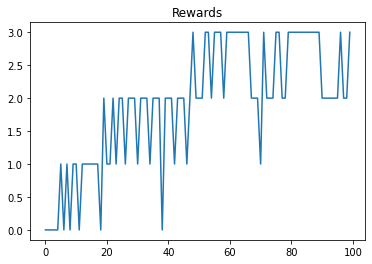

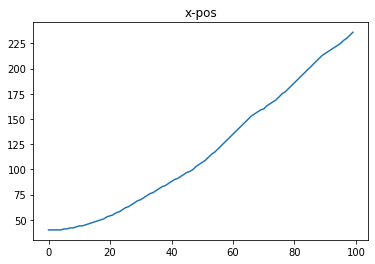

Sum of rewards is  191


In [ ]:
plt.plot(rewards)
plt.title('Rewards')
plt.show()

plt.plot(xs)
plt.title('x-pos')
plt.show()

print('Sum of rewards is ', rewards.sum())

# Preprocess the frames

In [ ]:
import cv2

def preprocess(frame):
  frame = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
  frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
  return frame/255.0

In [ ]:
env.reset()
obs, reward, done, info = env.step(1)

In [ ]:
obs.shape

(240, 256, 3)

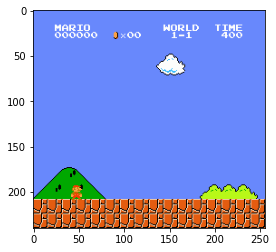

In [ ]:
plt.imshow(obs)

In [ ]:
state = preprocess(obs)

In [ ]:
state.shape

(84, 84)

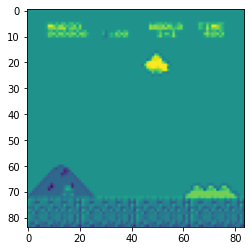

In [ ]:
plt.imshow(state)

# Q-Network

In [ ]:
class DQN(nn.Module):
  def __init__(self, channels, action_size, seed=42):
    super(DQN, self).__init__()
    self.conv1 = nn.Conv2d(channels, 32, 8, stride=4)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(64, 64, 3, stride=1)
    self.bn3 = nn.BatchNorm2d(64)

    self.fc1 = nn.Linear(64*7*7, 512)
    self.fc2 = nn.Linear(512, action_size)

  def forward(self, x):
    x = F.leaky_relu(self.bn1(self.conv1(x)))
    x = F.leaky_relu(self.bn2(self.conv2(x)))
    x = F.leaky_relu(self.bn3(self.conv3(x)))

    x = x.view(x.size()[0], -1)
  
    x = F.leaky_relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
# net = DQN(1, 5)
# net = net.float()
# print(net)

In [ ]:
# from torchviz import make_dot
# input = torch.from_numpy(state).unsqueeze(0).unsqueeze(0)
# action = net(input.float())
# make_dot(action, params=dict(net.named_parameters())).render("./log/network.png", format="png")

# Replay Memory

In [ ]:
class ReplayMemory():
  # To store and sample previous transactions
  def __init__(self, state_size, buffer_size, batch_size):
    self.states = torch.zeros((buffer_size,) + state_size).to(device)
    self.next_states = torch.zeros((buffer_size,) + state_size).to(device)
    self.actions = torch.zeros(buffer_size, 1, dtype=torch.long).to(device)
    self.rewards = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)
    self.dones = torch.zeros(buffer_size, 1, dtype=torch.float).to(device)

    self.ptr = 0
    self.full = False
    self.buffer_size = buffer_size
    self.batch_size = batch_size
    
  def add(self, state, action, reward, next_state, done):
    # Add a new experience to memory.
    self.states[self.ptr] = torch.from_numpy(state).to(device)
    self.next_states[self.ptr] = torch.from_numpy(next_state).to(device)
    self.actions[self.ptr] = action
    self.rewards[self.ptr] = reward
    self.dones[self.ptr] = done
        
    self.ptr += 1
    if self.ptr >= self.buffer_size:
      self.ptr = 0
      self.full = True

  def sample(self, n=32):
    # Randomly sample a mini batch of experiences from memory.
    if self.full:
      idx = np.random.choice(self.buffer_size, n, replace=False)
    else:
      idx = np.random.choice(self.ptr, n, replace=False)
        
    states = self.states[idx]
    next_states = self.next_states[idx]
    actions = self.actions[idx]
    rewards = self.rewards[idx]
    dones = self.dones[idx]
        
    return states, actions, rewards, next_states, dones
  
  def get_count(self):
    if self.full:
      return self.buffer_size
    else:
      return self.ptr

# Agent

In [ ]:
class Agent():
  def __init__(self, state_size, action_size, memory_size, batch_size, 
               gamma=0.9, update_every=1000, learning_rate=2e-4, seed=42):
    self.state_size = state_size
    self.action_size = action_size
    self.memory_size = memory_size
    self.batch_size = batch_size
    self.gamma = gamma
    self.update_every = update_every

    # Q-Network
    print('Initialize Q-Network')
    self.qnetwork_local = DQN(state_size[0], action_size, seed).to(device)
    self.qnetwork_target = DQN(state_size[0], action_size, seed).to(device)
    self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate)

    # Replay memory
    print('Initialize Replay Memory')
    self.memory = ReplayMemory(state_size, memory_size, batch_size)

    self.t_step = 0
    
  def experience_replay(self, state, action, reward, next_state, done):
    # Save experience in replay memory
    self.memory.add(state, action, reward, next_state, done)
        
    if self.memory.get_count() > self.batch_size:
      experiences = self.memory.sample(self.batch_size)
      self.learn(experiences)

  def act(self, state, epsilon=0.1):
    state = torch.from_numpy(state).float()
    state = state.unsqueeze(0).to(device)

    self.qnetwork_local.eval()
    with torch.no_grad():
      action_values = self.qnetwork_local(state)
    self.qnetwork_local.train()

    # Epsilon-greedy action selection
    if random.random() > epsilon:
       return np.argmax(action_values.cpu().data.numpy())
    else:
       return random.choice(np.arange(self.action_size))

  def learn(self, experiences):
    states, actions, rewards, next_states, dones = experiences

    self.optimizer.zero_grad()
    with torch.no_grad():
      maxQ = self.qnetwork_target(next_states).max(-1, keepdim=True)[0]
      target = rewards + self.gamma * maxQ * (1-dones)

    old_val = self.qnetwork_local(states).gather(-1, actions)   
        
    loss = F.smooth_l1_loss(old_val, target)
    loss.backward()
    self.optimizer.step()

    self.t_step += 1 
    if self.t_step % self.update_every == 0:
      self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

# Training

In [ ]:
MEMORY_SIZE = int(5e4)
BATCH_SIZE = 32
GAMMA = 0.9
LEARNING_RATE = 2e-4      
UPDATE_EVERY = 1000

EPOCH = 1000

noise = 1
noise_decay = 0.99
noise_min = 0.05

# number of frames fed to Q-network
MAX_FRAMES = 4
FRAME_SHAPE = (84, 84)

In [ ]:
action_size = len(action_space)
state_size = (MAX_FRAMES,) + FRAME_SHAPE
print(state_size)

(4, 84, 84)


In [ ]:
agent = Agent(state_size, action_size, MEMORY_SIZE, BATCH_SIZE, GAMMA, UPDATE_EVERY, LEARNING_RATE)

Initialize Q-Network
Initialize Replay Memory


In [ ]:
sum_rewards = []
previous_frames = deque(maxlen=MAX_FRAMES)

for e in tqdm(range(EPOCH)):
  obs = env.reset()
  prev_obs = None
  sum_reward = 0
    
  for i in range(MAX_FRAMES):
    previous_frames.append(np.zeros(FRAME_SHAPE))

  previous_frames.append(np.copy(preprocess(obs)))
  # print(previous_frames.shape)
  states = np.array(previous_frames)

  done = False
  while not done:
    actions = agent.act(states, noise)
    obs, reward, done, _ = env.step(actions)
    previous_frames.append(np.copy(preprocess(obs)))
    next_states = np.array(previous_frames)
        
    agent.experience_replay(states, int(actions), int(reward), next_states, int(done))
    sum_reward += reward
    states = next_states
  
    noise *= noise_decay
    noise = max(noise, noise_min)
    
  sum_rewards.append(sum_reward)
    
  tqdm.write('Episode {}\tCurrent Reward: {:.2f}'.format(e, sum_rewards[-1]))

  # display average reward every 50 iterations
  if (e+1) % 20 == 0:
    print('==========')
    print("Epoch: {0:d}, average reward: {1:f}".format(e+1,np.mean(sum_rewards[-20:])))
    print('==========')

  0%|          | 1/1000 [00:27<7:37:57, 27.50s/it]

Episode 0	Current Reward: 942.00


  0%|          | 2/1000 [00:45<6:50:38, 24.69s/it]

Episode 1	Current Reward: 760.00


  0%|          | 3/1000 [00:46<4:53:43, 17.68s/it]

Episode 2	Current Reward: 248.00


  0%|          | 4/1000 [00:48<3:31:56, 12.77s/it]

Episode 3	Current Reward: 246.00


  0%|          | 5/1000 [00:51<2:45:09,  9.96s/it]

Episode 4	Current Reward: 635.00


  1%|          | 6/1000 [00:55<2:12:45,  8.01s/it]

Episode 5	Current Reward: 639.00


  1%|          | 7/1000 [01:37<5:04:11, 18.38s/it]

Episode 6	Current Reward: 876.00


  1%|          | 8/1000 [01:44<4:07:40, 14.98s/it]

Episode 7	Current Reward: 579.00


  1%|          | 9/1000 [01:46<2:59:30, 10.87s/it]

Episode 8	Current Reward: 252.00


  1%|          | 10/1000 [01:59<3:12:56, 11.69s/it]

Episode 9	Current Reward: 781.00


  1%|          | 11/1000 [02:08<2:57:06, 10.75s/it]

Episode 10	Current Reward: 578.00


  1%|          | 12/1000 [02:17<2:48:25, 10.23s/it]

Episode 11	Current Reward: 626.00


  1%|▏         | 13/1000 [02:23<2:28:39,  9.04s/it]

Episode 12	Current Reward: 639.00


  1%|▏         | 14/1000 [02:25<1:52:29,  6.85s/it]

Episode 13	Current Reward: 242.00


  2%|▏         | 15/1000 [02:31<1:50:05,  6.71s/it]

Episode 14	Current Reward: 638.00


  2%|▏         | 16/1000 [02:43<2:16:24,  8.32s/it]

Episode 15	Current Reward: 692.00


  2%|▏         | 17/1000 [02:45<1:43:54,  6.34s/it]

Episode 16	Current Reward: 245.00


  2%|▏         | 18/1000 [02:50<1:36:19,  5.89s/it]

Episode 17	Current Reward: 588.00


  2%|▏         | 19/1000 [02:52<1:16:15,  4.66s/it]

Episode 18	Current Reward: 250.00


  2%|▏         | 20/1000 [03:05<1:59:52,  7.34s/it]

Episode 19	Current Reward: 1547.00
Epoch: 20, average reward: 600.150000


  2%|▏         | 21/1000 [03:07<1:31:15,  5.59s/it]

Episode 20	Current Reward: 252.00


  2%|▏         | 22/1000 [03:08<1:11:20,  4.38s/it]

Episode 21	Current Reward: 247.00


  2%|▏         | 23/1000 [03:27<2:22:55,  8.78s/it]

Episode 22	Current Reward: 988.00


  2%|▏         | 24/1000 [03:29<1:48:21,  6.66s/it]

Episode 23	Current Reward: 232.00


  2%|▎         | 25/1000 [03:34<1:39:29,  6.12s/it]

Episode 24	Current Reward: 580.00


  3%|▎         | 26/1000 [03:45<2:03:33,  7.61s/it]

Episode 25	Current Reward: 1325.00


  3%|▎         | 27/1000 [03:46<1:34:14,  5.81s/it]

Episode 26	Current Reward: 243.00


  3%|▎         | 28/1000 [03:59<2:07:09,  7.85s/it]

Episode 27	Current Reward: 1559.00


  3%|▎         | 29/1000 [04:06<2:01:59,  7.54s/it]

Episode 28	Current Reward: 637.00


  3%|▎         | 30/1000 [04:11<1:48:57,  6.74s/it]

Episode 29	Current Reward: 603.00


  3%|▎         | 31/1000 [04:15<1:37:17,  6.02s/it]

Episode 30	Current Reward: 622.00


  3%|▎         | 32/1000 [04:19<1:26:56,  5.39s/it]

Episode 31	Current Reward: 636.00


  3%|▎         | 33/1000 [04:25<1:29:53,  5.58s/it]

Episode 32	Current Reward: 740.00


  3%|▎         | 34/1000 [04:32<1:36:00,  5.96s/it]

Episode 33	Current Reward: 583.00


  4%|▎         | 35/1000 [04:43<2:00:11,  7.47s/it]

Episode 34	Current Reward: 733.00


  4%|▎         | 36/1000 [04:59<2:41:22, 10.04s/it]

Episode 35	Current Reward: 696.00


  4%|▎         | 37/1000 [05:02<2:08:36,  8.01s/it]

Episode 36	Current Reward: 637.00


  4%|▍         | 38/1000 [05:04<1:37:29,  6.08s/it]

Episode 37	Current Reward: 247.00


  4%|▍         | 39/1000 [05:05<1:14:30,  4.65s/it]

Episode 38	Current Reward: 251.00


  4%|▍         | 40/1000 [05:12<1:25:40,  5.35s/it]

Episode 39	Current Reward: 713.00
Epoch: 40, average reward: 626.200000


  4%|▍         | 41/1000 [05:23<1:50:45,  6.93s/it]

Episode 40	Current Reward: 757.00


  4%|▍         | 42/1000 [05:24<1:23:56,  5.26s/it]

Episode 41	Current Reward: 248.00


  4%|▍         | 43/1000 [05:26<1:05:47,  4.12s/it]

Episode 42	Current Reward: 241.00


  4%|▍         | 44/1000 [05:30<1:06:36,  4.18s/it]

Episode 43	Current Reward: 602.00


  4%|▍         | 45/1000 [05:31<54:04,  3.40s/it]  

Episode 44	Current Reward: 249.00


  5%|▍         | 46/1000 [05:52<2:15:56,  8.55s/it]

Episode 45	Current Reward: 1295.00


  5%|▍         | 47/1000 [05:59<2:07:16,  8.01s/it]

Episode 46	Current Reward: 732.00


  5%|▍         | 48/1000 [06:11<2:28:11,  9.34s/it]

Episode 47	Current Reward: 1041.00


  5%|▍         | 49/1000 [06:26<2:52:30, 10.88s/it]

Episode 48	Current Reward: 1009.00


  5%|▌         | 50/1000 [06:27<2:08:22,  8.11s/it]

Episode 49	Current Reward: 238.00


  5%|▌         | 51/1000 [06:29<1:36:51,  6.12s/it]

Episode 50	Current Reward: 236.00


  5%|▌         | 52/1000 [06:30<1:14:14,  4.70s/it]

Episode 51	Current Reward: 249.00


  5%|▌         | 53/1000 [06:32<58:44,  3.72s/it]  

Episode 52	Current Reward: 243.00


  5%|▌         | 54/1000 [06:33<48:52,  3.10s/it]

Episode 53	Current Reward: 239.00


  6%|▌         | 55/1000 [06:40<1:07:14,  4.27s/it]

Episode 54	Current Reward: 637.00


  6%|▌         | 56/1000 [06:42<53:07,  3.38s/it]  

Episode 55	Current Reward: 248.00


  6%|▌         | 57/1000 [07:01<2:10:07,  8.28s/it]

Episode 56	Current Reward: 987.00


  6%|▌         | 58/1000 [07:08<2:04:20,  7.92s/it]

Episode 57	Current Reward: 637.00


  6%|▌         | 59/1000 [07:15<1:57:47,  7.51s/it]

Episode 58	Current Reward: 639.00


  6%|▌         | 60/1000 [07:37<3:06:08, 11.88s/it]

Episode 59	Current Reward: 571.00
Epoch: 60, average reward: 554.900000


  6%|▌         | 61/1000 [07:55<3:35:42, 13.78s/it]

Episode 60	Current Reward: 992.00


  6%|▌         | 62/1000 [07:57<2:37:59, 10.11s/it]

Episode 61	Current Reward: 249.00


  6%|▋         | 63/1000 [08:03<2:20:02,  8.97s/it]

Episode 62	Current Reward: 594.00


  6%|▋         | 64/1000 [08:05<1:46:23,  6.82s/it]

Episode 63	Current Reward: 227.00


  6%|▋         | 65/1000 [08:09<1:35:14,  6.11s/it]

Episode 64	Current Reward: 613.00


  7%|▋         | 66/1000 [09:00<5:03:27, 19.49s/it]

Episode 65	Current Reward: 983.00


  7%|▋         | 67/1000 [09:19<4:59:39, 19.27s/it]

Episode 66	Current Reward: 596.00


  7%|▋         | 68/1000 [09:37<4:54:14, 18.94s/it]

Episode 67	Current Reward: 761.00


  7%|▋         | 69/1000 [09:48<4:15:53, 16.49s/it]

Episode 68	Current Reward: 612.00


  7%|▋         | 70/1000 [10:06<4:22:42, 16.95s/it]

Episode 69	Current Reward: 772.00


  7%|▋         | 71/1000 [10:30<4:54:14, 19.00s/it]

Episode 70	Current Reward: 1032.00


  7%|▋         | 72/1000 [10:33<3:41:05, 14.29s/it]

Episode 71	Current Reward: 249.00


  7%|▋         | 73/1000 [11:01<4:44:28, 18.41s/it]

Episode 72	Current Reward: 1024.00


  7%|▋         | 74/1000 [11:28<5:25:41, 21.10s/it]

Episode 73	Current Reward: 1025.00


  8%|▊         | 75/1000 [12:36<9:02:25, 35.18s/it]

Episode 74	Current Reward: 725.00


  8%|▊         | 76/1000 [12:40<6:35:41, 25.69s/it]

Episode 75	Current Reward: 245.00


  8%|▊         | 77/1000 [12:48<5:13:53, 20.40s/it]

Episode 76	Current Reward: 613.00


  8%|▊         | 78/1000 [13:04<4:54:53, 19.19s/it]

Episode 77	Current Reward: 639.00


  8%|▊         | 79/1000 [13:08<3:44:15, 14.61s/it]

Episode 78	Current Reward: 252.00


  8%|▊         | 80/1000 [13:19<3:24:44, 13.35s/it]

Episode 79	Current Reward: 635.00
Epoch: 80, average reward: 641.900000


  8%|▊         | 81/1000 [13:36<3:45:03, 14.69s/it]

Episode 80	Current Reward: 637.00


  8%|▊         | 82/1000 [13:40<2:54:05, 11.38s/it]

Episode 81	Current Reward: 250.00


  8%|▊         | 83/1000 [15:24<9:57:03, 39.07s/it]

Episode 82	Current Reward: 663.00


  8%|▊         | 84/1000 [15:28<7:17:54, 28.68s/it]

Episode 83	Current Reward: 243.00


  8%|▊         | 85/1000 [15:42<6:07:36, 24.11s/it]

Episode 84	Current Reward: 606.00


  9%|▊         | 86/1000 [15:58<5:31:00, 21.73s/it]

Episode 85	Current Reward: 639.00


  9%|▊         | 87/1000 [16:01<4:08:07, 16.31s/it]

Episode 86	Current Reward: 246.00


  9%|▉         | 88/1000 [17:29<9:31:28, 37.60s/it]

Episode 87	Current Reward: 920.00


  9%|▉         | 89/1000 [17:45<7:51:53, 31.08s/it]

Episode 88	Current Reward: 640.00


  9%|▉         | 90/1000 [18:31<9:01:37, 35.71s/it]

Episode 89	Current Reward: 762.00


  9%|▉         | 91/1000 [19:27<10:33:57, 41.85s/it]

Episode 90	Current Reward: 746.00


  9%|▉         | 92/1000 [19:44<8:37:51, 34.22s/it] 

Episode 91	Current Reward: 639.00


  9%|▉         | 93/1000 [19:48<6:19:21, 25.10s/it]

Episode 92	Current Reward: 248.00


  9%|▉         | 94/1000 [20:35<8:00:39, 31.83s/it]

Episode 93	Current Reward: 1292.00


 10%|▉         | 95/1000 [20:52<6:50:43, 27.23s/it]

Episode 94	Current Reward: 639.00


 10%|▉         | 96/1000 [21:10<6:09:56, 24.55s/it]

Episode 95	Current Reward: 759.00


 10%|▉         | 97/1000 [21:22<5:11:12, 20.68s/it]

Episode 96	Current Reward: 624.00


 10%|▉         | 98/1000 [21:34<4:31:38, 18.07s/it]

Episode 97	Current Reward: 610.00


 10%|▉         | 99/1000 [22:29<7:20:16, 29.32s/it]

Episode 98	Current Reward: 979.00


 10%|█         | 100/1000 [22:58<7:19:55, 29.33s/it]

Episode 99	Current Reward: 1035.00
Epoch: 100, average reward: 658.850000


 10%|█         | 101/1000 [23:11<6:05:20, 24.38s/it]

Episode 100	Current Reward: 625.00


 10%|█         | 102/1000 [23:15<4:34:06, 18.31s/it]

Episode 101	Current Reward: 236.00


 10%|█         | 103/1000 [24:08<7:06:05, 28.50s/it]

Episode 102	Current Reward: 753.00


 10%|█         | 104/1000 [24:12<5:18:52, 21.35s/it]

Episode 103	Current Reward: 246.00


 10%|█         | 105/1000 [25:43<10:28:37, 42.14s/it]

Episode 104	Current Reward: 582.00


 11%|█         | 106/1000 [27:09<13:42:03, 55.17s/it]

Episode 105	Current Reward: 1595.00


 11%|█         | 107/1000 [27:12<9:49:47, 39.63s/it] 

Episode 106	Current Reward: 246.00


 11%|█         | 108/1000 [27:15<7:08:07, 28.80s/it]

Episode 107	Current Reward: 247.00


 11%|█         | 109/1000 [27:32<6:11:11, 25.00s/it]

Episode 108	Current Reward: 639.00


 11%|█         | 110/1000 [27:36<4:39:09, 18.82s/it]

Episode 109	Current Reward: 231.00


 11%|█         | 111/1000 [27:42<3:40:16, 14.87s/it]

Episode 110	Current Reward: 227.00


 11%|█         | 112/1000 [27:57<3:44:10, 15.15s/it]

Episode 111	Current Reward: 640.00


 11%|█▏        | 113/1000 [28:29<4:58:04, 20.16s/it]

Episode 112	Current Reward: 582.00


 11%|█▏        | 114/1000 [28:33<3:44:49, 15.23s/it]

Episode 113	Current Reward: 245.00


 12%|█▏        | 115/1000 [28:46<3:32:47, 14.43s/it]

Episode 114	Current Reward: 588.00


 12%|█▏        | 116/1000 [28:49<2:46:00, 11.27s/it]

Episode 115	Current Reward: 234.00


 12%|█▏        | 117/1000 [30:06<7:32:10, 30.73s/it]

Episode 116	Current Reward: 1232.00


 12%|█▏        | 118/1000 [30:45<8:09:31, 33.30s/it]

Episode 117	Current Reward: 774.00


 12%|█▏        | 119/1000 [30:56<6:32:45, 26.75s/it]

Episode 118	Current Reward: 588.00


 12%|█▏        | 120/1000 [31:30<7:03:08, 28.85s/it]

Episode 119	Current Reward: 1306.00
Epoch: 120, average reward: 590.800000


 12%|█▏        | 121/1000 [31:36<5:19:45, 21.83s/it]

Episode 120	Current Reward: 224.00


 12%|█▏        | 122/1000 [31:40<4:05:02, 16.75s/it]

Episode 121	Current Reward: 232.00


 12%|█▏        | 123/1000 [32:01<4:21:16, 17.88s/it]

Episode 122	Current Reward: 565.00


 12%|█▏        | 124/1000 [33:33<9:44:24, 40.03s/it]

Episode 123	Current Reward: 1303.00


 12%|█▎        | 125/1000 [34:13<9:44:24, 40.07s/it]

Episode 124	Current Reward: 1286.00


 13%|█▎        | 126/1000 [35:19<11:36:10, 47.79s/it]

Episode 125	Current Reward: 1245.00


 13%|█▎        | 127/1000 [35:34<9:14:16, 38.09s/it] 

Episode 126	Current Reward: 625.00


 13%|█▎        | 128/1000 [36:00<8:22:22, 34.57s/it]

Episode 127	Current Reward: 784.00


 13%|█▎        | 129/1000 [36:27<7:48:07, 32.25s/it]

Episode 128	Current Reward: 762.00


 13%|█▎        | 130/1000 [36:42<6:30:57, 26.96s/it]

Episode 129	Current Reward: 627.00


 13%|█▎        | 131/1000 [36:46<4:51:07, 20.10s/it]

Episode 130	Current Reward: 233.00


 13%|█▎        | 132/1000 [37:02<4:34:56, 19.01s/it]

Episode 131	Current Reward: 615.00


 13%|█▎        | 133/1000 [37:23<4:42:42, 19.56s/it]

Episode 132	Current Reward: 1035.00


 13%|█▎        | 134/1000 [37:28<3:35:45, 14.95s/it]

Episode 133	Current Reward: 226.00


 14%|█▎        | 135/1000 [37:35<3:03:59, 12.76s/it]

Episode 134	Current Reward: 240.00


 14%|█▎        | 136/1000 [37:41<2:33:54, 10.69s/it]

Episode 135	Current Reward: 221.00


 14%|█▎        | 137/1000 [37:48<2:18:06,  9.60s/it]

Episode 136	Current Reward: 232.00


 14%|█▍        | 138/1000 [38:36<5:03:26, 21.12s/it]

Episode 137	Current Reward: 754.00


 14%|█▍        | 139/1000 [38:40<3:49:24, 15.99s/it]

Episode 138	Current Reward: 247.00


 14%|█▍        | 140/1000 [38:50<3:21:57, 14.09s/it]

Episode 139	Current Reward: 601.00
Epoch: 140, average reward: 602.850000


 14%|█▍        | 141/1000 [39:48<6:30:40, 27.29s/it]

Episode 140	Current Reward: 1252.00


 14%|█▍        | 142/1000 [40:12<6:15:29, 26.26s/it]

Episode 141	Current Reward: 623.00


 14%|█▍        | 143/1000 [40:30<5:39:38, 23.78s/it]

Episode 142	Current Reward: 794.00


 14%|█▍        | 144/1000 [40:34<4:15:06, 17.88s/it]

Episode 143	Current Reward: 228.00


 14%|█▍        | 145/1000 [40:46<3:51:49, 16.27s/it]

Episode 144	Current Reward: 582.00


 15%|█▍        | 146/1000 [40:55<3:20:32, 14.09s/it]

Episode 145	Current Reward: 626.00


 15%|█▍        | 147/1000 [41:16<3:47:19, 15.99s/it]

Episode 146	Current Reward: 806.00


 15%|█▍        | 148/1000 [41:32<3:47:28, 16.02s/it]

Episode 147	Current Reward: 638.00


 15%|█▍        | 149/1000 [41:59<4:36:08, 19.47s/it]

Episode 148	Current Reward: 793.00


 15%|█▌        | 150/1000 [42:03<3:30:23, 14.85s/it]

Episode 149	Current Reward: 246.00


 15%|█▌        | 151/1000 [42:07<2:43:19, 11.54s/it]

Episode 150	Current Reward: 247.00


 15%|█▌        | 152/1000 [42:11<2:09:45,  9.18s/it]

Episode 151	Current Reward: 248.00


 15%|█▌        | 153/1000 [42:21<2:15:06,  9.57s/it]

Episode 152	Current Reward: 608.00


 15%|█▌        | 154/1000 [42:32<2:19:22,  9.89s/it]

Episode 153	Current Reward: 633.00


 16%|█▌        | 155/1000 [43:43<6:36:37, 28.16s/it]

Episode 154	Current Reward: 1219.00


 16%|█▌        | 156/1000 [44:05<6:11:48, 26.43s/it]

Episode 155	Current Reward: 724.00


 16%|█▌        | 157/1000 [44:24<5:37:07, 24.00s/it]

Episode 156	Current Reward: 587.00


 16%|█▌        | 158/1000 [44:30<4:22:03, 18.67s/it]

Episode 157	Current Reward: 243.00


 16%|█▌        | 159/1000 [44:37<3:33:26, 15.23s/it]

Episode 158	Current Reward: 198.00


 16%|█▌        | 160/1000 [44:41<2:46:25, 11.89s/it]

Episode 159	Current Reward: 247.00
Epoch: 160, average reward: 577.100000


 16%|█▌        | 161/1000 [44:45<2:12:15,  9.46s/it]

Episode 160	Current Reward: 244.00


 16%|█▌        | 162/1000 [45:09<3:15:03, 13.97s/it]

Episode 161	Current Reward: 1025.00


 16%|█▋        | 163/1000 [45:27<3:28:23, 14.94s/it]

Episode 162	Current Reward: 636.00


 16%|█▋        | 164/1000 [45:46<3:47:31, 16.33s/it]

Episode 163	Current Reward: 631.00


 16%|█▋        | 165/1000 [47:14<8:44:12, 37.67s/it]

Episode 164	Current Reward: 652.00


 17%|█▋        | 166/1000 [47:28<7:07:30, 30.76s/it]

Episode 165	Current Reward: 613.00


 17%|█▋        | 167/1000 [48:14<8:11:13, 35.38s/it]

Episode 166	Current Reward: 739.00


 17%|█▋        | 168/1000 [49:29<10:55:08, 47.25s/it]

Episode 167	Current Reward: 661.00


 17%|█▋        | 169/1000 [49:45<8:42:11, 37.70s/it] 

Episode 168	Current Reward: 1004.00


 17%|█▋        | 170/1000 [50:08<7:39:47, 33.24s/it]

Episode 169	Current Reward: 651.00


 17%|█▋        | 171/1000 [50:17<6:00:31, 26.09s/it]

Episode 170	Current Reward: 626.00


 17%|█▋        | 172/1000 [50:19<4:19:02, 18.77s/it]

Episode 171	Current Reward: 238.00


 17%|█▋        | 173/1000 [50:20<3:07:18, 13.59s/it]

Episode 172	Current Reward: 248.00


 17%|█▋        | 174/1000 [50:22<2:18:50, 10.09s/it]

Episode 173	Current Reward: 241.00


 18%|█▊        | 175/1000 [50:24<1:46:22,  7.74s/it]

Episode 174	Current Reward: 241.00


 18%|█▊        | 176/1000 [50:26<1:19:45,  5.81s/it]

Episode 175	Current Reward: 252.00


 18%|█▊        | 177/1000 [50:43<2:05:59,  9.19s/it]

Episode 176	Current Reward: 996.00


 18%|█▊        | 178/1000 [50:54<2:16:23,  9.96s/it]

Episode 177	Current Reward: 1315.00


 18%|█▊        | 179/1000 [50:56<1:41:44,  7.44s/it]

Episode 178	Current Reward: 247.00


 18%|█▊        | 180/1000 [51:05<1:46:51,  7.82s/it]

Episode 179	Current Reward: 576.00
Epoch: 180, average reward: 591.800000


 18%|█▊        | 181/1000 [51:14<1:53:05,  8.29s/it]

Episode 180	Current Reward: 586.00


 18%|█▊        | 182/1000 [51:50<3:44:28, 16.47s/it]

Episode 181	Current Reward: 1119.00


 18%|█▊        | 183/1000 [51:53<2:50:00, 12.49s/it]

Episode 182	Current Reward: 242.00


 18%|█▊        | 184/1000 [52:30<4:31:02, 19.93s/it]

Episode 183	Current Reward: 1290.00


 18%|█▊        | 185/1000 [52:47<4:17:42, 18.97s/it]

Episode 184	Current Reward: 637.00


 19%|█▊        | 186/1000 [53:06<4:17:28, 18.98s/it]

Episode 185	Current Reward: 808.00


 19%|█▊        | 187/1000 [53:10<3:18:17, 14.63s/it]

Episode 186	Current Reward: 248.00


 19%|█▉        | 188/1000 [53:15<2:36:11, 11.54s/it]

Episode 187	Current Reward: 233.00


 19%|█▉        | 189/1000 [53:27<2:40:24, 11.87s/it]

Episode 188	Current Reward: 591.00


 19%|█▉        | 190/1000 [54:17<5:13:14, 23.20s/it]

Episode 189	Current Reward: 1248.00


 19%|█▉        | 191/1000 [56:29<12:31:55, 55.77s/it]

Episode 190	Current Reward: 1139.00


 19%|█▉        | 192/1000 [56:54<10:26:14, 46.50s/it]

Episode 191	Current Reward: 604.00


 19%|█▉        | 193/1000 [57:30<9:46:23, 43.60s/it] 

Episode 192	Current Reward: 716.00


 19%|█▉        | 194/1000 [57:53<8:21:56, 37.37s/it]

Episode 193	Current Reward: 1332.00


 20%|█▉        | 195/1000 [58:18<7:31:57, 33.69s/it]

Episode 194	Current Reward: 1049.00


 20%|█▉        | 196/1000 [58:22<5:29:14, 24.57s/it]

Episode 195	Current Reward: 239.00


 20%|█▉        | 197/1000 [58:25<4:04:28, 18.27s/it]

Episode 196	Current Reward: 241.00


 20%|█▉        | 198/1000 [59:07<5:39:27, 25.40s/it]

Episode 197	Current Reward: 1274.00


 20%|█▉        | 199/1000 [59:28<5:19:45, 23.95s/it]

Episode 198	Current Reward: 630.00


 20%|██        | 200/1000 [59:44<4:47:17, 21.55s/it]

Episode 199	Current Reward: 638.00
Epoch: 200, average reward: 743.200000


 20%|██        | 201/1000 [59:49<3:41:21, 16.62s/it]

Episode 200	Current Reward: 217.00


 20%|██        | 202/1000 [1:00:11<4:02:46, 18.25s/it]

Episode 201	Current Reward: 627.00


 20%|██        | 203/1000 [1:00:18<3:17:29, 14.87s/it]

Episode 202	Current Reward: 188.00


 20%|██        | 204/1000 [1:00:22<2:35:22, 11.71s/it]

Episode 203	Current Reward: 245.00


 20%|██        | 205/1000 [1:01:16<5:20:56, 24.22s/it]

Episode 204	Current Reward: 568.00


 21%|██        | 206/1000 [1:04:53<18:06:43, 82.12s/it]

Episode 205	Current Reward: 443.00


 21%|██        | 207/1000 [1:05:17<14:14:11, 64.63s/it]

Episode 206	Current Reward: 1326.00


 21%|██        | 208/1000 [1:05:28<10:43:04, 48.72s/it]

Episode 207	Current Reward: 588.00


 21%|██        | 209/1000 [1:05:33<7:47:29, 35.46s/it] 

Episode 208	Current Reward: 247.00


 21%|██        | 210/1000 [1:06:22<8:41:44, 39.63s/it]

Episode 209	Current Reward: 980.00


 21%|██        | 211/1000 [1:07:30<10:33:17, 48.16s/it]

Episode 210	Current Reward: 657.00


 21%|██        | 212/1000 [1:07:36<7:45:54, 35.48s/it] 

Episode 211	Current Reward: 247.00


 21%|██▏       | 213/1000 [1:07:39<5:38:44, 25.83s/it]

Episode 212	Current Reward: 250.00


 21%|██▏       | 214/1000 [1:07:53<4:50:11, 22.15s/it]

Episode 213	Current Reward: 584.00


 22%|██▏       | 215/1000 [1:07:56<3:35:54, 16.50s/it]

Episode 214	Current Reward: 248.00


 22%|██▏       | 216/1000 [1:09:30<8:36:53, 39.56s/it]

Episode 215	Current Reward: 898.00


 22%|██▏       | 217/1000 [1:11:28<13:42:45, 63.05s/it]

Episode 216	Current Reward: 2901.00


 22%|██▏       | 218/1000 [1:11:46<10:46:07, 49.57s/it]

Episode 217	Current Reward: 1047.00


 22%|██▏       | 219/1000 [1:11:59<8:23:54, 38.71s/it] 

Episode 218	Current Reward: 591.00


 22%|██▏       | 220/1000 [1:12:08<6:28:27, 29.88s/it]

Episode 219	Current Reward: 614.00
Epoch: 220, average reward: 673.300000


 22%|██▏       | 221/1000 [1:12:12<4:44:16, 21.89s/it]

Episode 220	Current Reward: 250.00


 22%|██▏       | 222/1000 [1:12:39<5:05:35, 23.57s/it]

Episode 221	Current Reward: 728.00


 22%|██▏       | 223/1000 [1:13:09<5:27:54, 25.32s/it]

Episode 222	Current Reward: 1016.00


 22%|██▏       | 224/1000 [1:13:35<5:30:55, 25.59s/it]

Episode 223	Current Reward: 795.00


 22%|██▎       | 225/1000 [1:13:43<4:22:01, 20.29s/it]

Episode 224	Current Reward: 610.00


 23%|██▎       | 226/1000 [1:15:29<9:53:47, 46.03s/it]

Episode 225	Current Reward: 875.00


 23%|██▎       | 227/1000 [1:15:40<7:37:54, 35.54s/it]

Episode 226	Current Reward: 634.00


 23%|██▎       | 228/1000 [1:15:44<5:34:53, 26.03s/it]

Episode 227	Current Reward: 233.00


 23%|██▎       | 229/1000 [1:16:05<5:16:37, 24.64s/it]

Episode 228	Current Reward: 628.00


 23%|██▎       | 230/1000 [1:16:47<6:21:28, 29.72s/it]

Episode 229	Current Reward: 700.00


 23%|██▎       | 231/1000 [1:16:50<4:38:52, 21.76s/it]

Episode 230	Current Reward: 249.00


 23%|██▎       | 232/1000 [1:17:11<4:37:34, 21.69s/it]

Episode 231	Current Reward: 613.00


 23%|██▎       | 233/1000 [1:18:08<6:52:15, 32.25s/it]

Episode 232	Current Reward: 965.00


 23%|██▎       | 234/1000 [1:18:11<5:00:11, 23.51s/it]

Episode 233	Current Reward: 248.00


 24%|██▎       | 235/1000 [1:18:26<4:26:18, 20.89s/it]

Episode 234	Current Reward: 780.00


 24%|██▎       | 236/1000 [1:18:30<3:20:45, 15.77s/it]

Episode 235	Current Reward: 238.00


 24%|██▎       | 237/1000 [1:18:33<2:33:28, 12.07s/it]

Episode 236	Current Reward: 246.00


 24%|██▍       | 238/1000 [1:18:59<3:24:35, 16.11s/it]

Episode 237	Current Reward: 795.00


 24%|██▍       | 239/1000 [1:19:02<2:36:05, 12.31s/it]

Episode 238	Current Reward: 240.00


 24%|██▍       | 240/1000 [1:19:06<2:03:42,  9.77s/it]

Episode 239	Current Reward: 235.00
Epoch: 240, average reward: 553.900000


 24%|██▍       | 241/1000 [1:19:50<4:13:40, 20.05s/it]

Episode 240	Current Reward: 990.00


 24%|██▍       | 242/1000 [1:20:14<4:26:14, 21.08s/it]

Episode 241	Current Reward: 799.00


 24%|██▍       | 243/1000 [1:20:40<4:44:08, 22.52s/it]

Episode 242	Current Reward: 711.00


 24%|██▍       | 244/1000 [1:20:55<4:16:14, 20.34s/it]

Episode 243	Current Reward: 578.00


 24%|██▍       | 245/1000 [1:21:18<4:27:25, 21.25s/it]

Episode 244	Current Reward: 623.00


 25%|██▍       | 246/1000 [1:22:05<6:02:34, 28.85s/it]

Episode 245	Current Reward: 747.00


 25%|██▍       | 247/1000 [1:22:29<5:45:06, 27.50s/it]

Episode 246	Current Reward: 1317.00


 25%|██▍       | 248/1000 [1:22:46<5:03:56, 24.25s/it]

Episode 247	Current Reward: 607.00


 25%|██▍       | 249/1000 [1:23:13<5:13:30, 25.05s/it]

Episode 248	Current Reward: 793.00


 25%|██▌       | 250/1000 [1:23:36<5:07:07, 24.57s/it]

Episode 249	Current Reward: 752.00


 25%|██▌       | 251/1000 [1:23:53<4:37:06, 22.20s/it]

Episode 250	Current Reward: 609.00


 25%|██▌       | 252/1000 [1:24:14<4:32:08, 21.83s/it]

Episode 251	Current Reward: 738.00


 25%|██▌       | 253/1000 [1:25:11<6:44:09, 32.46s/it]

Episode 252	Current Reward: 966.00


 25%|██▌       | 254/1000 [1:25:41<6:35:58, 31.85s/it]

Episode 253	Current Reward: 1303.00


 26%|██▌       | 255/1000 [1:26:05<6:03:46, 29.30s/it]

Episode 254	Current Reward: 624.00


 26%|██▌       | 256/1000 [1:26:22<5:16:44, 25.54s/it]

Episode 255	Current Reward: 637.00


 26%|██▌       | 257/1000 [1:26:28<4:05:17, 19.81s/it]

Episode 256	Current Reward: 607.00


 26%|██▌       | 258/1000 [1:26:45<3:52:57, 18.84s/it]

Episode 257	Current Reward: 752.00


 26%|██▌       | 259/1000 [1:27:44<6:23:48, 31.08s/it]

Episode 258	Current Reward: 961.00


 26%|██▌       | 260/1000 [1:28:30<7:18:14, 35.53s/it]

Episode 259	Current Reward: 1532.00
Epoch: 260, average reward: 832.300000


 26%|██▌       | 261/1000 [1:29:04<7:09:47, 34.89s/it]

Episode 260	Current Reward: 1013.00


 26%|██▌       | 262/1000 [1:29:11<5:28:38, 26.72s/it]

Episode 261	Current Reward: 638.00


 26%|██▋       | 263/1000 [1:29:15<4:02:13, 19.72s/it]

Episode 262	Current Reward: 251.00


 26%|██▋       | 264/1000 [1:29:41<4:27:13, 21.78s/it]

Episode 263	Current Reward: 618.00


 26%|██▋       | 265/1000 [1:29:44<3:17:16, 16.10s/it]

Episode 264	Current Reward: 250.00


 27%|██▋       | 266/1000 [1:30:02<3:22:34, 16.56s/it]

Episode 265	Current Reward: 587.00


 27%|██▋       | 267/1000 [1:30:05<2:33:21, 12.55s/it]

Episode 266	Current Reward: 250.00


 27%|██▋       | 268/1000 [1:30:28<3:12:31, 15.78s/it]

Episode 267	Current Reward: 624.00


 27%|██▋       | 269/1000 [1:30:31<2:26:32, 12.03s/it]

Episode 268	Current Reward: 245.00


 27%|██▋       | 270/1000 [1:30:55<3:08:14, 15.47s/it]

Episode 269	Current Reward: 579.00


 27%|██▋       | 271/1000 [1:30:59<2:24:36, 11.90s/it]

Episode 270	Current Reward: 234.00


 27%|██▋       | 272/1000 [1:31:02<1:52:31,  9.27s/it]

Episode 271	Current Reward: 244.00


 27%|██▋       | 273/1000 [1:31:18<2:16:52, 11.30s/it]

Episode 272	Current Reward: 607.00


 27%|██▋       | 274/1000 [1:31:28<2:12:20, 10.94s/it]

Episode 273	Current Reward: 590.00


 28%|██▊       | 275/1000 [1:32:19<4:36:26, 22.88s/it]

Episode 274	Current Reward: 976.00


 28%|██▊       | 276/1000 [1:32:22<3:23:55, 16.90s/it]

Episode 275	Current Reward: 248.00


 28%|██▊       | 277/1000 [1:32:45<3:45:52, 18.74s/it]

Episode 276	Current Reward: 569.00


 28%|██▊       | 278/1000 [1:32:48<2:48:45, 14.02s/it]

Episode 277	Current Reward: 250.00


 28%|██▊       | 279/1000 [1:33:16<3:39:32, 18.27s/it]

Episode 278	Current Reward: 615.00


 28%|██▊       | 280/1000 [1:33:34<3:38:18, 18.19s/it]

Episode 279	Current Reward: 810.00
Epoch: 280, average reward: 509.900000


 28%|██▊       | 281/1000 [1:33:49<3:28:15, 17.38s/it]

Episode 280	Current Reward: 774.00


 28%|██▊       | 282/1000 [1:33:56<2:48:42, 14.10s/it]

Episode 281	Current Reward: 611.00


 28%|██▊       | 283/1000 [1:34:09<2:44:33, 13.77s/it]

Episode 282	Current Reward: 586.00


 28%|██▊       | 284/1000 [1:34:23<2:46:43, 13.97s/it]

Episode 283	Current Reward: 640.00


 28%|██▊       | 285/1000 [1:34:52<3:38:35, 18.34s/it]

Episode 284	Current Reward: 613.00


 29%|██▊       | 286/1000 [1:35:52<6:09:33, 31.05s/it]

Episode 285	Current Reward: 961.00


 29%|██▊       | 287/1000 [1:36:29<6:28:32, 32.70s/it]

Episode 286	Current Reward: 774.00


 29%|██▉       | 288/1000 [1:36:40<5:11:45, 26.27s/it]

Episode 287	Current Reward: 598.00


 29%|██▉       | 289/1000 [1:37:38<7:05:04, 35.87s/it]

Episode 288	Current Reward: 734.00


 29%|██▉       | 290/1000 [1:38:38<8:27:39, 42.90s/it]

Episode 289	Current Reward: 1254.00


 29%|██▉       | 291/1000 [1:40:48<13:37:43, 69.20s/it]

Episode 290	Current Reward: 852.00


 29%|██▉       | 292/1000 [1:41:03<10:24:59, 52.97s/it]

Episode 291	Current Reward: 640.00


 29%|██▉       | 293/1000 [1:43:31<15:58:56, 81.38s/it]

Episode 292	Current Reward: 798.00


 29%|██▉       | 294/1000 [1:43:35<11:24:29, 58.17s/it]

Episode 293	Current Reward: 229.00


 30%|██▉       | 295/1000 [1:43:39<8:10:57, 41.78s/it] 

Episode 294	Current Reward: 246.00


 30%|██▉       | 296/1000 [1:43:42<5:55:46, 30.32s/it]

Episode 295	Current Reward: 242.00


 30%|██▉       | 297/1000 [1:45:20<9:53:51, 50.69s/it]

Episode 296	Current Reward: 886.00


 30%|██▉       | 298/1000 [1:48:58<19:37:53, 100.67s/it]

Episode 297	Current Reward: 267.00


 30%|██▉       | 299/1000 [1:49:05<14:07:27, 72.54s/it] 

Episode 298	Current Reward: 609.00


 30%|███       | 300/1000 [1:49:16<10:31:30, 54.13s/it]

Episode 299	Current Reward: 606.00
Epoch: 300, average reward: 646.000000


 30%|███       | 301/1000 [1:49:43<8:56:23, 46.04s/it] 

Episode 300	Current Reward: 1023.00


 30%|███       | 302/1000 [1:49:52<6:46:21, 34.93s/it]

Episode 301	Current Reward: 635.00


 30%|███       | 303/1000 [1:50:23<6:33:07, 33.84s/it]

Episode 302	Current Reward: 785.00


 30%|███       | 304/1000 [1:50:27<4:47:09, 24.76s/it]

Episode 303	Current Reward: 245.00


 30%|███       | 305/1000 [1:50:30<3:33:05, 18.40s/it]

Episode 304	Current Reward: 237.00


 31%|███       | 306/1000 [1:50:35<2:44:45, 14.24s/it]

Episode 305	Current Reward: 225.00


 31%|███       | 307/1000 [1:51:14<4:09:02, 21.56s/it]

Episode 306	Current Reward: 1001.00


 31%|███       | 308/1000 [1:51:42<4:33:34, 23.72s/it]

Episode 307	Current Reward: 1018.00


 31%|███       | 309/1000 [1:52:09<4:43:26, 24.61s/it]

Episode 308	Current Reward: 794.00


 31%|███       | 310/1000 [1:52:20<3:56:28, 20.56s/it]

Episode 309	Current Reward: 597.00


 31%|███       | 311/1000 [1:53:25<6:27:15, 33.72s/it]

Episode 310	Current Reward: 1232.00


 31%|███       | 312/1000 [1:53:41<5:27:36, 28.57s/it]

Episode 311	Current Reward: 637.00


 31%|███▏      | 313/1000 [1:53:44<3:59:24, 20.91s/it]

Episode 312	Current Reward: 249.00


 31%|███▏      | 314/1000 [1:53:55<3:23:33, 17.80s/it]

Episode 313	Current Reward: 589.00


 32%|███▏      | 315/1000 [1:54:18<3:40:51, 19.34s/it]

Episode 314	Current Reward: 1427.00


 32%|███▏      | 316/1000 [1:54:39<3:46:35, 19.88s/it]

Episode 315	Current Reward: 750.00


 32%|███▏      | 317/1000 [1:54:42<2:49:15, 14.87s/it]

Episode 316	Current Reward: 248.00


 32%|███▏      | 318/1000 [1:54:45<2:09:16, 11.37s/it]

Episode 317	Current Reward: 248.00


 32%|███▏      | 319/1000 [1:55:00<2:21:04, 12.43s/it]

Episode 318	Current Reward: 641.00


 32%|███▏      | 320/1000 [1:55:16<2:33:08, 13.51s/it]

Episode 319	Current Reward: 766.00
Epoch: 320, average reward: 667.350000


 32%|███▏      | 321/1000 [1:55:40<3:08:48, 16.68s/it]

Episode 320	Current Reward: 737.00


 32%|███▏      | 322/1000 [1:55:44<2:23:08, 12.67s/it]

Episode 321	Current Reward: 243.00


 32%|███▏      | 323/1000 [1:55:46<1:50:06,  9.76s/it]

Episode 322	Current Reward: 246.00


 32%|███▏      | 324/1000 [1:56:08<2:29:32, 13.27s/it]

Episode 323	Current Reward: 1334.00


 32%|███▎      | 325/1000 [1:56:12<1:56:56, 10.39s/it]

Episode 324	Current Reward: 243.00


 33%|███▎      | 326/1000 [1:56:19<1:48:10,  9.63s/it]

Episode 325	Current Reward: 637.00


 33%|███▎      | 327/1000 [1:56:42<2:30:06, 13.38s/it]

Episode 326	Current Reward: 1317.00


 33%|███▎      | 328/1000 [1:56:58<2:39:26, 14.24s/it]

Episode 327	Current Reward: 573.00


 33%|███▎      | 329/1000 [1:57:22<3:12:55, 17.25s/it]

Episode 328	Current Reward: 622.00


 33%|███▎      | 330/1000 [1:57:59<4:19:17, 23.22s/it]

Episode 329	Current Reward: 1822.00


 33%|███▎      | 331/1000 [1:58:08<3:30:40, 18.89s/it]

Episode 330	Current Reward: 651.00


 33%|███▎      | 332/1000 [1:58:12<2:40:08, 14.38s/it]

Episode 331	Current Reward: 242.00


 33%|███▎      | 333/1000 [1:58:29<2:48:25, 15.15s/it]

Episode 332	Current Reward: 1041.00


 33%|███▎      | 334/1000 [1:58:51<3:11:10, 17.22s/it]

Episode 333	Current Reward: 626.00


 34%|███▎      | 335/1000 [1:59:18<3:44:28, 20.25s/it]

Episode 334	Current Reward: 792.00


 34%|███▎      | 336/1000 [2:00:06<5:16:33, 28.60s/it]

Episode 335	Current Reward: 3032.00


 34%|███▎      | 337/1000 [2:00:24<4:40:49, 25.41s/it]

Episode 336	Current Reward: 763.00


 34%|███▍      | 338/1000 [2:00:40<4:08:51, 22.56s/it]

Episode 337	Current Reward: 638.00


 34%|███▍      | 339/1000 [2:00:44<3:06:27, 16.92s/it]

Episode 338	Current Reward: 233.00


 34%|███▍      | 340/1000 [2:01:07<3:26:00, 18.73s/it]

Episode 339	Current Reward: 1717.00
Epoch: 340, average reward: 875.450000


 34%|███▍      | 341/1000 [2:01:10<2:34:47, 14.09s/it]

Episode 340	Current Reward: 240.00


 34%|███▍      | 342/1000 [2:01:32<2:59:22, 16.36s/it]

Episode 341	Current Reward: 1033.00


 34%|███▍      | 343/1000 [2:02:07<4:01:07, 22.02s/it]

Episode 342	Current Reward: 1004.00


 34%|███▍      | 344/1000 [2:02:36<4:22:48, 24.04s/it]

Episode 343	Current Reward: 1028.00


 34%|███▍      | 345/1000 [2:03:01<4:26:34, 24.42s/it]

Episode 344	Current Reward: 1561.00


 35%|███▍      | 346/1000 [2:03:11<3:37:18, 19.94s/it]

Episode 345	Current Reward: 634.00


 35%|███▍      | 347/1000 [2:03:14<2:44:28, 15.11s/it]

Episode 346	Current Reward: 228.00


 35%|███▍      | 348/1000 [2:03:33<2:55:23, 16.14s/it]

Episode 347	Current Reward: 715.00


 35%|███▍      | 349/1000 [2:03:37<2:14:34, 12.40s/it]

Episode 348	Current Reward: 232.00


 35%|███▌      | 350/1000 [2:03:56<2:35:56, 14.39s/it]

Episode 349	Current Reward: 1326.00


 35%|███▌      | 351/1000 [2:04:19<3:05:55, 17.19s/it]

Episode 350	Current Reward: 1028.00


 35%|███▌      | 352/1000 [2:04:28<2:36:43, 14.51s/it]

Episode 351	Current Reward: 637.00


 35%|███▌      | 353/1000 [2:04:56<3:20:52, 18.63s/it]

Episode 352	Current Reward: 790.00


 35%|███▌      | 354/1000 [2:05:00<2:32:47, 14.19s/it]

Episode 353	Current Reward: 243.00


 36%|███▌      | 355/1000 [2:05:03<1:58:13, 11.00s/it]

Episode 354	Current Reward: 249.00


 36%|███▌      | 356/1000 [2:05:24<2:29:38, 13.94s/it]

Episode 355	Current Reward: 1045.00


 36%|███▌      | 357/1000 [2:05:27<1:54:18, 10.67s/it]

Episode 356	Current Reward: 251.00


 36%|███▌      | 358/1000 [2:05:58<2:57:29, 16.59s/it]

Episode 357	Current Reward: 1294.00


 36%|███▌      | 359/1000 [2:06:01<2:16:02, 12.73s/it]

Episode 358	Current Reward: 244.00


 36%|███▌      | 360/1000 [2:06:05<1:48:19, 10.16s/it]

Episode 359	Current Reward: 243.00
Epoch: 360, average reward: 701.250000


 36%|███▌      | 361/1000 [2:06:32<2:39:12, 14.95s/it]

Episode 360	Current Reward: 1331.00


 36%|███▌      | 362/1000 [2:06:35<2:01:12, 11.40s/it]

Episode 361	Current Reward: 246.00


 36%|███▋      | 363/1000 [2:06:50<2:13:19, 12.56s/it]

Episode 362	Current Reward: 610.00


 36%|███▋      | 364/1000 [2:07:33<3:48:31, 21.56s/it]

Episode 363	Current Reward: 695.00


 36%|███▋      | 365/1000 [2:07:35<2:49:04, 15.98s/it]

Episode 364	Current Reward: 246.00


 37%|███▋      | 366/1000 [2:07:50<2:43:16, 15.45s/it]

Episode 365	Current Reward: 640.00


 37%|███▋      | 367/1000 [2:08:11<3:02:59, 17.35s/it]

Episode 366	Current Reward: 802.00


 37%|███▋      | 368/1000 [2:08:15<2:18:48, 13.18s/it]

Episode 367	Current Reward: 247.00


 37%|███▋      | 369/1000 [2:09:06<4:17:34, 24.49s/it]

Episode 368	Current Reward: 1633.00


 37%|███▋      | 370/1000 [2:09:17<3:34:08, 20.40s/it]

Episode 369	Current Reward: 632.00


 37%|███▋      | 371/1000 [2:09:34<3:25:00, 19.56s/it]

Episode 370	Current Reward: 810.00


 37%|███▋      | 372/1000 [2:09:38<2:35:31, 14.86s/it]

Episode 371	Current Reward: 245.00


 37%|███▋      | 373/1000 [2:09:42<1:59:33, 11.44s/it]

Episode 372	Current Reward: 235.00


 37%|███▋      | 374/1000 [2:10:05<2:36:10, 14.97s/it]

Episode 373	Current Reward: 799.00


 38%|███▊      | 375/1000 [2:10:35<3:21:59, 19.39s/it]

Episode 374	Current Reward: 612.00


 38%|███▊      | 376/1000 [2:10:57<3:30:49, 20.27s/it]

Episode 375	Current Reward: 614.00


 38%|███▊      | 377/1000 [2:11:00<2:37:50, 15.20s/it]

Episode 376	Current Reward: 236.00


 38%|███▊      | 378/1000 [2:11:03<1:59:28, 11.52s/it]

Episode 377	Current Reward: 251.00


 38%|███▊      | 379/1000 [2:12:22<5:29:31, 31.84s/it]

Episode 378	Current Reward: 921.00


 38%|███▊      | 380/1000 [2:12:26<4:01:20, 23.36s/it]

Episode 379	Current Reward: 249.00
Epoch: 380, average reward: 602.700000


 38%|███▊      | 381/1000 [2:12:51<4:06:49, 23.93s/it]

Episode 380	Current Reward: 786.00


 38%|███▊      | 382/1000 [2:12:54<3:01:50, 17.65s/it]

Episode 381	Current Reward: 246.00


 38%|███▊      | 383/1000 [2:13:02<2:30:50, 14.67s/it]

Episode 382	Current Reward: 653.00


 38%|███▊      | 384/1000 [2:13:30<3:11:09, 18.62s/it]

Episode 383	Current Reward: 1323.00


 38%|███▊      | 385/1000 [2:14:00<3:46:18, 22.08s/it]

Episode 384	Current Reward: 788.00


 39%|███▊      | 386/1000 [2:14:16<3:27:26, 20.27s/it]

Episode 385	Current Reward: 785.00


 39%|███▊      | 387/1000 [2:14:20<2:37:14, 15.39s/it]

Episode 386	Current Reward: 225.00


 39%|███▉      | 388/1000 [2:15:03<4:00:55, 23.62s/it]

Episode 387	Current Reward: 992.00


 39%|███▉      | 389/1000 [2:15:18<3:35:11, 21.13s/it]

Episode 388	Current Reward: 624.00


 39%|███▉      | 390/1000 [2:16:10<5:08:53, 30.38s/it]

Episode 389	Current Reward: 977.00


 39%|███▉      | 391/1000 [2:16:18<3:59:06, 23.56s/it]

Episode 390	Current Reward: 653.00


 39%|███▉      | 392/1000 [2:16:45<4:10:46, 24.75s/it]

Episode 391	Current Reward: 689.00


 39%|███▉      | 393/1000 [2:16:57<3:31:29, 20.90s/it]

Episode 392	Current Reward: 583.00


 39%|███▉      | 394/1000 [2:17:23<3:45:51, 22.36s/it]

Episode 393	Current Reward: 1405.00


 40%|███▉      | 395/1000 [2:17:39<3:26:42, 20.50s/it]

Episode 394	Current Reward: 637.00


 40%|███▉      | 396/1000 [2:17:42<2:34:19, 15.33s/it]

Episode 395	Current Reward: 249.00


 40%|███▉      | 397/1000 [2:18:23<3:50:22, 22.92s/it]

Episode 396	Current Reward: 999.00


 40%|███▉      | 398/1000 [2:18:46<3:51:39, 23.09s/it]

Episode 397	Current Reward: 1033.00


 40%|███▉      | 399/1000 [2:18:50<2:51:44, 17.15s/it]

Episode 398	Current Reward: 251.00


 40%|████      | 400/1000 [2:21:34<10:12:40, 61.27s/it]

Episode 399	Current Reward: 771.00
Epoch: 400, average reward: 733.450000


 40%|████      | 401/1000 [2:21:53<8:05:13, 48.60s/it] 

Episode 400	Current Reward: 752.00


 40%|████      | 402/1000 [2:22:21<7:01:52, 42.33s/it]

Episode 401	Current Reward: 1415.00


 40%|████      | 403/1000 [2:22:37<5:44:34, 34.63s/it]

Episode 402	Current Reward: 771.00


 40%|████      | 404/1000 [2:23:08<5:30:38, 33.29s/it]

Episode 403	Current Reward: 1016.00


 40%|████      | 405/1000 [2:23:21<4:30:20, 27.26s/it]

Episode 404	Current Reward: 803.00


 41%|████      | 406/1000 [2:23:32<3:42:42, 22.50s/it]

Episode 405	Current Reward: 791.00


 41%|████      | 407/1000 [2:23:44<3:10:49, 19.31s/it]

Episode 406	Current Reward: 1316.00


 41%|████      | 408/1000 [2:23:50<2:32:28, 15.45s/it]

Episode 407	Current Reward: 638.00


 41%|████      | 409/1000 [2:24:03<2:22:16, 14.44s/it]

Episode 408	Current Reward: 612.00


 41%|████      | 410/1000 [2:24:13<2:09:34, 13.18s/it]

Episode 409	Current Reward: 1025.00


 41%|████      | 411/1000 [2:24:27<2:11:02, 13.35s/it]

Episode 410	Current Reward: 780.00


 41%|████      | 412/1000 [2:24:42<2:16:55, 13.97s/it]

Episode 411	Current Reward: 1296.00


 41%|████▏     | 413/1000 [2:24:43<1:39:26, 10.16s/it]

Episode 412	Current Reward: 248.00


 41%|████▏     | 414/1000 [2:25:22<3:02:07, 18.65s/it]

Episode 413	Current Reward: 894.00


 42%|████▏     | 415/1000 [2:25:45<3:15:48, 20.08s/it]

Episode 414	Current Reward: 1255.00


 42%|████▏     | 416/1000 [2:26:00<2:59:12, 18.41s/it]

Episode 415	Current Reward: 601.00


 42%|████▏     | 417/1000 [2:26:03<2:13:54, 13.78s/it]

Episode 416	Current Reward: 608.00


 42%|████▏     | 418/1000 [2:27:16<5:08:23, 31.79s/it]

Episode 417	Current Reward: 2078.00


 42%|████▏     | 419/1000 [2:27:37<4:34:45, 28.37s/it]

Episode 418	Current Reward: 628.00


 42%|████▏     | 420/1000 [2:27:45<3:36:07, 22.36s/it]

Episode 419	Current Reward: 634.00
Epoch: 420, average reward: 908.050000


 42%|████▏     | 421/1000 [2:27:48<2:40:01, 16.58s/it]

Episode 420	Current Reward: 248.00


 42%|████▏     | 422/1000 [2:28:12<3:01:19, 18.82s/it]

Episode 421	Current Reward: 1333.00


 42%|████▏     | 423/1000 [2:28:16<2:16:43, 14.22s/it]

Episode 422	Current Reward: 242.00


 42%|████▏     | 424/1000 [2:28:28<2:10:06, 13.55s/it]

Episode 423	Current Reward: 616.00


 42%|████▎     | 425/1000 [2:28:37<1:58:46, 12.39s/it]

Episode 424	Current Reward: 626.00


 43%|████▎     | 426/1000 [2:28:58<2:22:08, 14.86s/it]

Episode 425	Current Reward: 1042.00


 43%|████▎     | 427/1000 [2:29:01<1:48:25, 11.35s/it]

Episode 426	Current Reward: 251.00


 43%|████▎     | 428/1000 [2:30:26<5:19:15, 33.49s/it]

Episode 427	Current Reward: 1207.00


 43%|████▎     | 429/1000 [2:30:30<3:54:20, 24.62s/it]

Episode 428	Current Reward: 240.00


 43%|████▎     | 430/1000 [2:30:47<3:32:34, 22.38s/it]

Episode 429	Current Reward: 813.00


 43%|████▎     | 431/1000 [2:31:08<3:27:16, 21.86s/it]

Episode 430	Current Reward: 807.00


 43%|████▎     | 432/1000 [2:31:33<3:34:35, 22.67s/it]

Episode 431	Current Reward: 1036.00


 43%|████▎     | 433/1000 [2:35:11<12:49:15, 81.40s/it]

Episode 432	Current Reward: 263.00


 43%|████▎     | 434/1000 [2:36:40<13:08:27, 83.58s/it]

Episode 433	Current Reward: 639.00


 44%|████▎     | 435/1000 [2:37:16<10:54:26, 69.50s/it]

Episode 434	Current Reward: 1006.00


 44%|████▎     | 436/1000 [2:37:20<7:46:20, 49.61s/it] 

Episode 435	Current Reward: 248.00


 44%|████▎     | 437/1000 [2:39:13<10:44:12, 68.66s/it]

Episode 436	Current Reward: 1138.00


 44%|████▍     | 438/1000 [2:39:39<8:43:15, 55.86s/it] 

Episode 437	Current Reward: 795.00


 44%|████▍     | 439/1000 [2:39:56<6:54:19, 44.31s/it]

Episode 438	Current Reward: 635.00


 44%|████▍     | 440/1000 [2:40:00<5:01:42, 32.33s/it]

Episode 439	Current Reward: 240.00
Epoch: 440, average reward: 671.250000


 44%|████▍     | 441/1000 [2:40:15<4:10:18, 26.87s/it]

Episode 440	Current Reward: 573.00


 44%|████▍     | 442/1000 [2:40:31<3:40:16, 23.69s/it]

Episode 441	Current Reward: 585.00


 44%|████▍     | 443/1000 [2:40:56<3:43:25, 24.07s/it]

Episode 442	Current Reward: 1320.00


 44%|████▍     | 444/1000 [2:41:00<2:46:53, 18.01s/it]

Episode 443	Current Reward: 231.00


 44%|████▍     | 445/1000 [2:41:20<2:53:48, 18.79s/it]

Episode 444	Current Reward: 574.00


 45%|████▍     | 446/1000 [2:41:42<3:02:51, 19.81s/it]

Episode 445	Current Reward: 1039.00


 45%|████▍     | 447/1000 [2:42:12<3:28:26, 22.62s/it]

Episode 446	Current Reward: 1304.00


 45%|████▍     | 448/1000 [2:42:15<2:34:35, 16.80s/it]

Episode 447	Current Reward: 247.00


 45%|████▍     | 449/1000 [2:42:58<3:47:19, 24.75s/it]

Episode 448	Current Reward: 992.00


 45%|████▌     | 450/1000 [2:43:19<3:36:41, 23.64s/it]

Episode 449	Current Reward: 1034.00


 45%|████▌     | 451/1000 [2:43:47<3:47:18, 24.84s/it]

Episode 450	Current Reward: 1028.00


 45%|████▌     | 452/1000 [2:44:11<3:45:14, 24.66s/it]

Episode 451	Current Reward: 702.00


 45%|████▌     | 453/1000 [2:44:36<3:44:50, 24.66s/it]

Episode 452	Current Reward: 1048.00


 45%|████▌     | 454/1000 [2:44:39<2:45:33, 18.19s/it]

Episode 453	Current Reward: 251.00


 46%|████▌     | 455/1000 [2:44:47<2:18:05, 15.20s/it]

Episode 454	Current Reward: 630.00


 46%|████▌     | 456/1000 [2:44:55<1:57:00, 12.90s/it]

Episode 455	Current Reward: 612.00


 46%|████▌     | 457/1000 [2:44:58<1:31:06, 10.07s/it]

Episode 456	Current Reward: 243.00


 46%|████▌     | 458/1000 [2:45:18<1:58:48, 13.15s/it]

Episode 457	Current Reward: 735.00


 46%|████▌     | 459/1000 [2:45:55<3:02:07, 20.20s/it]

Episode 458	Current Reward: 1117.00


 46%|████▌     | 460/1000 [2:46:23<3:23:08, 22.57s/it]

Episode 459	Current Reward: 1299.00
Epoch: 460, average reward: 778.200000


 46%|████▌     | 461/1000 [2:47:26<5:12:13, 34.76s/it]

Episode 460	Current Reward: 962.00


 46%|████▌     | 462/1000 [2:48:24<6:14:13, 41.74s/it]

Episode 461	Current Reward: 1249.00


 46%|████▋     | 463/1000 [2:48:57<5:48:16, 38.91s/it]

Episode 462	Current Reward: 1022.00


 46%|████▋     | 464/1000 [2:49:58<6:48:55, 45.78s/it]

Episode 463	Current Reward: 1239.00


 46%|████▋     | 465/1000 [2:50:48<6:58:02, 46.88s/it]

Episode 464	Current Reward: 984.00


 47%|████▋     | 466/1000 [2:51:20<6:17:57, 42.47s/it]

Episode 465	Current Reward: 727.00


 47%|████▋     | 467/1000 [2:51:24<4:35:01, 30.96s/it]

Episode 466	Current Reward: 240.00


 47%|████▋     | 468/1000 [2:51:35<3:40:50, 24.91s/it]

Episode 467	Current Reward: 618.00


 47%|████▋     | 469/1000 [2:52:36<5:15:14, 35.62s/it]

Episode 468	Current Reward: 1246.00


 47%|████▋     | 470/1000 [2:54:47<9:27:47, 64.28s/it]

Episode 469	Current Reward: 1115.00


 47%|████▋     | 471/1000 [2:54:50<6:45:08, 45.95s/it]

Episode 470	Current Reward: 249.00


 47%|████▋     | 472/1000 [2:55:16<5:51:11, 39.91s/it]

Episode 471	Current Reward: 708.00


 47%|████▋     | 473/1000 [2:55:38<5:05:02, 34.73s/it]

Episode 472	Current Reward: 1057.00


 47%|████▋     | 474/1000 [2:56:02<4:34:31, 31.31s/it]

Episode 473	Current Reward: 701.00


 48%|████▊     | 475/1000 [2:57:47<7:49:04, 53.61s/it]

Episode 474	Current Reward: 2932.00


 48%|████▊     | 476/1000 [2:58:32<7:25:12, 50.98s/it]

Episode 475	Current Reward: 1379.00


 48%|████▊     | 477/1000 [2:58:36<5:21:54, 36.93s/it]

Episode 476	Current Reward: 229.00


 48%|████▊     | 478/1000 [2:58:45<4:07:08, 28.41s/it]

Episode 477	Current Reward: 635.00


 48%|████▊     | 479/1000 [2:58:56<3:22:02, 23.27s/it]

Episode 478	Current Reward: 646.00


 48%|████▊     | 480/1000 [2:59:21<3:25:58, 23.77s/it]

Episode 479	Current Reward: 711.00
Epoch: 480, average reward: 932.450000


 48%|████▊     | 481/1000 [2:59:46<3:28:13, 24.07s/it]

Episode 480	Current Reward: 621.00


 48%|████▊     | 482/1000 [2:59:51<2:37:39, 18.26s/it]

Episode 481	Current Reward: 221.00


 48%|████▊     | 483/1000 [2:59:54<1:59:11, 13.83s/it]

Episode 482	Current Reward: 245.00


 48%|████▊     | 484/1000 [2:59:59<1:37:01, 11.28s/it]

Episode 483	Current Reward: 209.00


 48%|████▊     | 485/1000 [3:00:03<1:18:10,  9.11s/it]

Episode 484	Current Reward: 234.00


 49%|████▊     | 486/1000 [3:00:52<2:59:24, 20.94s/it]

Episode 485	Current Reward: 1090.00


 49%|████▊     | 487/1000 [3:01:45<4:22:29, 30.70s/it]

Episode 486	Current Reward: 1282.00


 49%|████▉     | 488/1000 [3:02:16<4:21:10, 30.61s/it]

Episode 487	Current Reward: 1321.00


 49%|████▉     | 489/1000 [3:02:44<4:13:13, 29.73s/it]

Episode 488	Current Reward: 1835.00


 49%|████▉     | 490/1000 [3:03:20<4:30:50, 31.86s/it]

Episode 489	Current Reward: 1681.00


 49%|████▉     | 491/1000 [3:03:49<4:22:52, 30.99s/it]

Episode 490	Current Reward: 1022.00


 49%|████▉     | 492/1000 [3:04:57<5:55:12, 41.95s/it]

Episode 491	Current Reward: 726.00


 49%|████▉     | 493/1000 [3:05:15<4:54:28, 34.85s/it]

Episode 492	Current Reward: 767.00


 49%|████▉     | 494/1000 [3:05:53<5:00:15, 35.60s/it]

Episode 493	Current Reward: 779.00


 50%|████▉     | 495/1000 [3:05:56<3:39:42, 26.10s/it]

Episode 494	Current Reward: 242.00


 50%|████▉     | 496/1000 [3:06:18<3:28:40, 24.84s/it]

Episode 495	Current Reward: 700.00


 50%|████▉     | 497/1000 [3:06:31<2:56:59, 21.11s/it]

Episode 496	Current Reward: 626.00


 50%|████▉     | 498/1000 [3:06:35<2:13:17, 15.93s/it]

Episode 497	Current Reward: 244.00


 50%|████▉     | 499/1000 [3:07:34<4:02:23, 29.03s/it]

Episode 498	Current Reward: 978.00


 50%|█████     | 500/1000 [3:07:43<3:12:00, 23.04s/it]

Episode 499	Current Reward: 605.00
Epoch: 500, average reward: 771.400000


 50%|█████     | 501/1000 [3:08:39<4:34:13, 32.97s/it]

Episode 500	Current Reward: 1349.00


 50%|█████     | 502/1000 [3:08:44<3:22:21, 24.38s/it]

Episode 501	Current Reward: 235.00


 50%|█████     | 503/1000 [3:09:01<3:05:20, 22.38s/it]

Episode 502	Current Reward: 774.00


 50%|█████     | 504/1000 [3:09:18<2:50:53, 20.67s/it]

Episode 503	Current Reward: 617.00


 50%|█████     | 505/1000 [3:09:53<3:25:52, 24.95s/it]

Episode 504	Current Reward: 1551.00


 51%|█████     | 506/1000 [3:10:25<3:41:50, 26.94s/it]

Episode 505	Current Reward: 789.00


 51%|█████     | 507/1000 [3:10:49<3:35:45, 26.26s/it]

Episode 506	Current Reward: 746.00


 51%|█████     | 508/1000 [3:11:06<3:12:24, 23.46s/it]

Episode 507	Current Reward: 629.00


 51%|█████     | 509/1000 [3:11:24<2:58:25, 21.80s/it]

Episode 508	Current Reward: 795.00


 51%|█████     | 510/1000 [3:11:28<2:14:01, 16.41s/it]

Episode 509	Current Reward: 244.00


 51%|█████     | 511/1000 [3:12:12<3:20:24, 24.59s/it]

Episode 510	Current Reward: 686.00


 51%|█████     | 512/1000 [3:12:21<2:41:36, 19.87s/it]

Episode 511	Current Reward: 622.00


 51%|█████▏    | 513/1000 [3:12:25<2:02:40, 15.11s/it]

Episode 512	Current Reward: 242.00


 51%|█████▏    | 514/1000 [3:13:02<2:55:26, 21.66s/it]

Episode 513	Current Reward: 1313.00


 52%|█████▏    | 515/1000 [3:13:29<3:09:24, 23.43s/it]

Episode 514	Current Reward: 1325.00


 52%|█████▏    | 516/1000 [3:13:47<2:54:57, 21.69s/it]

Episode 515	Current Reward: 637.00


 52%|█████▏    | 517/1000 [3:14:18<3:17:04, 24.48s/it]

Episode 516	Current Reward: 756.00


 52%|█████▏    | 518/1000 [3:14:26<2:37:27, 19.60s/it]

Episode 517	Current Reward: 612.00


 52%|█████▏    | 519/1000 [3:14:30<2:00:27, 15.03s/it]

Episode 518	Current Reward: 235.00


 52%|█████▏    | 520/1000 [3:14:43<1:55:25, 14.43s/it]

Episode 519	Current Reward: 613.00
Epoch: 520, average reward: 738.500000


 52%|█████▏    | 521/1000 [3:14:57<1:52:58, 14.15s/it]

Episode 520	Current Reward: 638.00


 52%|█████▏    | 522/1000 [3:16:14<4:23:22, 33.06s/it]

Episode 521	Current Reward: 1760.00


 52%|█████▏    | 523/1000 [3:16:52<4:33:28, 34.40s/it]

Episode 522	Current Reward: 1015.00


 52%|█████▏    | 524/1000 [3:17:08<3:49:33, 28.94s/it]

Episode 523	Current Reward: 640.00


 52%|█████▎    | 525/1000 [3:17:12<2:50:04, 21.48s/it]

Episode 524	Current Reward: 239.00


 53%|█████▎    | 526/1000 [3:17:29<2:38:25, 20.05s/it]

Episode 525	Current Reward: 782.00


 53%|█████▎    | 527/1000 [3:17:40<2:18:48, 17.61s/it]

Episode 526	Current Reward: 611.00


 53%|█████▎    | 528/1000 [3:18:22<3:15:52, 24.90s/it]

Episode 527	Current Reward: 1654.00


 53%|█████▎    | 529/1000 [3:18:34<2:44:52, 21.00s/it]

Episode 528	Current Reward: 624.00


 53%|█████▎    | 530/1000 [3:18:38<2:03:22, 15.75s/it]

Episode 529	Current Reward: 244.00


 53%|█████▎    | 531/1000 [3:18:47<1:48:22, 13.87s/it]

Episode 530	Current Reward: 608.00


 53%|█████▎    | 532/1000 [3:19:05<1:58:04, 15.14s/it]

Episode 531	Current Reward: 1042.00


 53%|█████▎    | 533/1000 [3:19:41<2:45:28, 21.26s/it]

Episode 532	Current Reward: 1019.00


 53%|█████▎    | 534/1000 [3:19:54<2:26:26, 18.86s/it]

Episode 533	Current Reward: 714.00


 54%|█████▎    | 535/1000 [3:20:35<3:17:18, 25.46s/it]

Episode 534	Current Reward: 1897.00


 54%|█████▎    | 536/1000 [3:20:38<2:25:14, 18.78s/it]

Episode 535	Current Reward: 249.00


 54%|█████▎    | 537/1000 [3:20:52<2:12:41, 17.20s/it]

Episode 536	Current Reward: 621.00


 54%|█████▍    | 538/1000 [3:21:03<1:59:35, 15.53s/it]

Episode 537	Current Reward: 628.00


 54%|█████▍    | 539/1000 [3:21:20<2:01:29, 15.81s/it]

Episode 538	Current Reward: 580.00


 54%|█████▍    | 540/1000 [3:21:36<2:02:10, 15.94s/it]

Episode 539	Current Reward: 815.00
Epoch: 540, average reward: 819.000000


 54%|█████▍    | 541/1000 [3:21:47<1:50:38, 14.46s/it]

Episode 540	Current Reward: 604.00


 54%|█████▍    | 542/1000 [3:21:51<1:26:16, 11.30s/it]

Episode 541	Current Reward: 239.00


 54%|█████▍    | 543/1000 [3:22:07<1:37:07, 12.75s/it]

Episode 542	Current Reward: 640.00


 54%|█████▍    | 544/1000 [3:22:19<1:35:37, 12.58s/it]

Episode 543	Current Reward: 582.00


 55%|█████▍    | 545/1000 [3:22:23<1:15:12,  9.92s/it]

Episode 544	Current Reward: 240.00


 55%|█████▍    | 546/1000 [3:22:41<1:32:27, 12.22s/it]

Episode 545	Current Reward: 784.00


 55%|█████▍    | 547/1000 [3:22:45<1:14:43,  9.90s/it]

Episode 546	Current Reward: 234.00


 55%|█████▍    | 548/1000 [3:22:49<1:01:12,  8.12s/it]

Episode 547	Current Reward: 249.00


 55%|█████▍    | 549/1000 [3:23:27<2:07:40, 16.99s/it]

Episode 548	Current Reward: 1234.00


 55%|█████▌    | 550/1000 [3:23:40<2:00:06, 16.01s/it]

Episode 549	Current Reward: 1013.00


 55%|█████▌    | 551/1000 [3:23:48<1:40:31, 13.43s/it]

Episode 550	Current Reward: 812.00


 55%|█████▌    | 552/1000 [3:24:03<1:44:05, 13.94s/it]

Episode 551	Current Reward: 1006.00


 55%|█████▌    | 553/1000 [3:24:05<1:17:13, 10.36s/it]

Episode 552	Current Reward: 227.00


 55%|█████▌    | 554/1000 [3:24:07<57:29,  7.73s/it]  

Episode 553	Current Reward: 240.00


 56%|█████▌    | 555/1000 [3:24:12<51:59,  7.01s/it]

Episode 554	Current Reward: 577.00


 56%|█████▌    | 556/1000 [3:24:13<39:31,  5.34s/it]

Episode 555	Current Reward: 249.00


 56%|█████▌    | 557/1000 [3:24:24<51:53,  7.03s/it]

Episode 556	Current Reward: 786.00


 56%|█████▌    | 558/1000 [3:24:37<1:03:09,  8.57s/it]

Episode 557	Current Reward: 1018.00


 56%|█████▌    | 559/1000 [3:24:46<1:05:49,  8.96s/it]

Episode 558	Current Reward: 1302.00


 56%|█████▌    | 560/1000 [3:24:54<1:02:27,  8.52s/it]

Episode 559	Current Reward: 619.00
Epoch: 560, average reward: 632.750000


 56%|█████▌    | 561/1000 [3:25:05<1:09:06,  9.45s/it]

Episode 560	Current Reward: 1043.00


 56%|█████▌    | 562/1000 [3:25:10<57:22,  7.86s/it]  

Episode 561	Current Reward: 240.00


 56%|█████▋    | 563/1000 [3:25:15<50:57,  7.00s/it]

Episode 562	Current Reward: 233.00


 56%|█████▋    | 564/1000 [3:25:19<44:25,  6.11s/it]

Episode 563	Current Reward: 235.00


 56%|█████▋    | 565/1000 [3:25:22<38:54,  5.37s/it]

Episode 564	Current Reward: 245.00


 57%|█████▋    | 566/1000 [3:25:31<46:55,  6.49s/it]

Episode 565	Current Reward: 633.00


 57%|█████▋    | 567/1000 [3:26:07<1:49:47, 15.21s/it]

Episode 566	Current Reward: 1006.00


 57%|█████▋    | 568/1000 [3:26:11<1:26:14, 11.98s/it]

Episode 567	Current Reward: 229.00


 57%|█████▋    | 569/1000 [3:26:22<1:24:04, 11.70s/it]

Episode 568	Current Reward: 589.00


 57%|█████▋    | 570/1000 [3:26:44<1:44:23, 14.57s/it]

Episode 569	Current Reward: 754.00


 57%|█████▋    | 571/1000 [3:26:54<1:35:02, 13.29s/it]

Episode 570	Current Reward: 619.00


 57%|█████▋    | 572/1000 [3:26:58<1:14:34, 10.45s/it]

Episode 571	Current Reward: 246.00


 57%|█████▋    | 573/1000 [3:27:44<2:31:24, 21.27s/it]

Episode 572	Current Reward: 988.00


 57%|█████▋    | 574/1000 [3:27:56<2:11:13, 18.48s/it]

Episode 573	Current Reward: 614.00


 57%|█████▊    | 575/1000 [3:28:15<2:10:32, 18.43s/it]

Episode 574	Current Reward: 754.00


 58%|█████▊    | 576/1000 [3:28:25<1:53:06, 16.01s/it]

Episode 575	Current Reward: 621.00


 58%|█████▊    | 577/1000 [3:28:47<2:05:43, 17.83s/it]

Episode 576	Current Reward: 715.00


 58%|█████▊    | 578/1000 [3:28:50<1:34:46, 13.48s/it]

Episode 577	Current Reward: 249.00


 58%|█████▊    | 579/1000 [3:29:06<1:39:42, 14.21s/it]

Episode 578	Current Reward: 640.00


 58%|█████▊    | 580/1000 [3:29:18<1:35:11, 13.60s/it]

Episode 579	Current Reward: 716.00
Epoch: 580, average reward: 568.450000


 58%|█████▊    | 581/1000 [3:29:23<1:15:02, 10.74s/it]

Episode 580	Current Reward: 242.00


 58%|█████▊    | 582/1000 [3:29:56<2:02:34, 17.59s/it]

Episode 581	Current Reward: 1899.00


 58%|█████▊    | 583/1000 [3:30:06<1:46:40, 15.35s/it]

Episode 582	Current Reward: 622.00


 58%|█████▊    | 584/1000 [3:30:10<1:22:08, 11.85s/it]

Episode 583	Current Reward: 238.00


 58%|█████▊    | 585/1000 [3:30:14<1:05:38,  9.49s/it]

Episode 584	Current Reward: 244.00


 59%|█████▊    | 586/1000 [3:30:24<1:05:54,  9.55s/it]

Episode 585	Current Reward: 623.00


 59%|█████▊    | 587/1000 [3:30:29<56:06,  8.15s/it]  

Episode 586	Current Reward: 228.00


 59%|█████▉    | 588/1000 [3:30:32<46:15,  6.74s/it]

Episode 587	Current Reward: 240.00


 59%|█████▉    | 589/1000 [3:31:04<1:37:49, 14.28s/it]

Episode 588	Current Reward: 1014.00


 59%|█████▉    | 590/1000 [3:31:45<2:32:57, 22.38s/it]

Episode 589	Current Reward: 1107.00


 59%|█████▉    | 591/1000 [3:31:49<1:55:00, 16.87s/it]

Episode 590	Current Reward: 246.00


 59%|█████▉    | 592/1000 [3:32:09<2:01:19, 17.84s/it]

Episode 591	Current Reward: 1341.00


 59%|█████▉    | 593/1000 [3:32:21<1:49:16, 16.11s/it]

Episode 592	Current Reward: 610.00


 59%|█████▉    | 594/1000 [3:32:52<2:19:04, 20.55s/it]

Episode 593	Current Reward: 1310.00


 60%|█████▉    | 595/1000 [3:32:56<1:44:51, 15.54s/it]

Episode 594	Current Reward: 247.00


 60%|█████▉    | 596/1000 [3:33:31<2:22:51, 21.22s/it]

Episode 595	Current Reward: 706.00


 60%|█████▉    | 597/1000 [3:33:34<1:46:10, 15.81s/it]

Episode 596	Current Reward: 249.00


 60%|█████▉    | 598/1000 [3:34:03<2:12:46, 19.82s/it]

Episode 597	Current Reward: 1414.00


 60%|█████▉    | 599/1000 [3:34:14<1:55:14, 17.24s/it]

Episode 598	Current Reward: 608.00


 60%|██████    | 600/1000 [3:34:25<1:41:20, 15.20s/it]

Episode 599	Current Reward: 620.00
Epoch: 600, average reward: 690.400000


 60%|██████    | 601/1000 [3:34:29<1:18:51, 11.86s/it]

Episode 600	Current Reward: 236.00


 60%|██████    | 602/1000 [3:34:56<1:48:59, 16.43s/it]

Episode 601	Current Reward: 1560.00


 60%|██████    | 603/1000 [3:35:16<1:56:42, 17.64s/it]

Episode 602	Current Reward: 791.00


 60%|██████    | 604/1000 [3:35:27<1:43:30, 15.68s/it]

Episode 603	Current Reward: 629.00


 60%|██████    | 605/1000 [3:36:01<2:18:37, 21.06s/it]

Episode 604	Current Reward: 1404.00


 61%|██████    | 606/1000 [3:36:28<2:30:26, 22.91s/it]

Episode 605	Current Reward: 1017.00


 61%|██████    | 607/1000 [3:36:49<2:25:25, 22.20s/it]

Episode 606	Current Reward: 753.00


 61%|██████    | 608/1000 [3:36:58<2:00:03, 18.38s/it]

Episode 607	Current Reward: 622.00


 61%|██████    | 609/1000 [3:37:01<1:30:25, 13.88s/it]

Episode 608	Current Reward: 249.00


 61%|██████    | 610/1000 [3:37:17<1:33:06, 14.32s/it]

Episode 609	Current Reward: 817.00


 61%|██████    | 611/1000 [3:37:49<2:07:51, 19.72s/it]

Episode 610	Current Reward: 1024.00


 61%|██████    | 612/1000 [3:38:21<2:30:39, 23.30s/it]

Episode 611	Current Reward: 1296.00


 61%|██████▏   | 613/1000 [3:38:31<2:04:26, 19.29s/it]

Episode 612	Current Reward: 636.00


 61%|██████▏   | 614/1000 [3:39:01<2:25:28, 22.61s/it]

Episode 613	Current Reward: 1043.00


 62%|██████▏   | 615/1000 [3:39:27<2:30:31, 23.46s/it]

Episode 614	Current Reward: 1023.00


 62%|██████▏   | 616/1000 [3:39:46<2:22:26, 22.26s/it]

Episode 615	Current Reward: 761.00


 62%|██████▏   | 617/1000 [3:39:58<2:02:27, 19.19s/it]

Episode 616	Current Reward: 606.00


 62%|██████▏   | 618/1000 [3:40:20<2:06:44, 19.91s/it]

Episode 617	Current Reward: 1034.00


 62%|██████▏   | 619/1000 [3:40:23<1:34:31, 14.89s/it]

Episode 618	Current Reward: 251.00


 62%|██████▏   | 620/1000 [3:40:36<1:31:19, 14.42s/it]

Episode 619	Current Reward: 594.00
Epoch: 620, average reward: 817.300000


 62%|██████▏   | 621/1000 [3:40:47<1:24:32, 13.38s/it]

Episode 620	Current Reward: 634.00


 62%|██████▏   | 622/1000 [3:40:51<1:07:12, 10.67s/it]

Episode 621	Current Reward: 232.00


 62%|██████▏   | 623/1000 [3:41:10<1:22:13, 13.09s/it]

Episode 622	Current Reward: 759.00


 62%|██████▏   | 624/1000 [3:41:14<1:04:24, 10.28s/it]

Episode 623	Current Reward: 241.00


 62%|██████▎   | 625/1000 [3:41:18<53:29,  8.56s/it]  

Episode 624	Current Reward: 217.00


 63%|██████▎   | 626/1000 [3:41:30<59:01,  9.47s/it]

Episode 625	Current Reward: 617.00


 63%|██████▎   | 627/1000 [3:41:51<1:20:49, 13.00s/it]

Episode 626	Current Reward: 1056.00


 63%|██████▎   | 628/1000 [3:41:55<1:03:29, 10.24s/it]

Episode 627	Current Reward: 238.00


 63%|██████▎   | 629/1000 [3:41:58<50:23,  8.15s/it]  

Episode 628	Current Reward: 248.00


 63%|██████▎   | 630/1000 [3:42:17<1:09:29, 11.27s/it]

Episode 629	Current Reward: 1042.00


 63%|██████▎   | 631/1000 [3:43:32<3:07:25, 30.47s/it]

Episode 630	Current Reward: 937.00


 63%|██████▎   | 632/1000 [3:43:58<2:58:41, 29.13s/it]

Episode 631	Current Reward: 689.00


 63%|██████▎   | 633/1000 [3:44:32<3:06:23, 30.47s/it]

Episode 632	Current Reward: 1296.00


 63%|██████▎   | 634/1000 [3:44:49<2:42:18, 26.61s/it]

Episode 633	Current Reward: 577.00


 64%|██████▎   | 635/1000 [3:45:10<2:31:50, 24.96s/it]

Episode 634	Current Reward: 751.00


 64%|██████▎   | 636/1000 [3:45:23<2:09:27, 21.34s/it]

Episode 635	Current Reward: 740.00


 64%|██████▎   | 637/1000 [3:45:30<1:42:50, 17.00s/it]

Episode 636	Current Reward: 611.00


 64%|██████▍   | 638/1000 [3:45:34<1:18:38, 13.04s/it]

Episode 637	Current Reward: 236.00


 64%|██████▍   | 639/1000 [3:49:11<7:26:15, 74.17s/it]

Episode 638	Current Reward: 987.00


 64%|██████▍   | 640/1000 [3:49:28<5:41:33, 56.93s/it]

Episode 639	Current Reward: 638.00
Epoch: 640, average reward: 637.300000


 64%|██████▍   | 641/1000 [3:49:31<4:05:20, 41.00s/it]

Episode 640	Current Reward: 241.00


 64%|██████▍   | 642/1000 [3:50:21<4:20:53, 43.73s/it]

Episode 641	Current Reward: 1005.00


 64%|██████▍   | 643/1000 [3:50:37<3:30:08, 35.32s/it]

Episode 642	Current Reward: 639.00


 64%|██████▍   | 644/1000 [3:51:19<3:40:19, 37.13s/it]

Episode 643	Current Reward: 997.00


 64%|██████▍   | 645/1000 [3:51:22<2:40:21, 27.10s/it]

Episode 644	Current Reward: 235.00


 65%|██████▍   | 646/1000 [3:51:54<2:48:06, 28.49s/it]

Episode 645	Current Reward: 1010.00


 65%|██████▍   | 647/1000 [3:52:10<2:25:03, 24.66s/it]

Episode 646	Current Reward: 639.00


 65%|██████▍   | 648/1000 [3:52:20<1:59:01, 20.29s/it]

Episode 647	Current Reward: 612.00


 65%|██████▍   | 649/1000 [3:52:22<1:26:41, 14.82s/it]

Episode 648	Current Reward: 228.00


 65%|██████▌   | 650/1000 [3:52:24<1:03:32, 10.89s/it]

Episode 649	Current Reward: 236.00


 65%|██████▌   | 651/1000 [3:52:38<1:10:00, 12.04s/it]

Episode 650	Current Reward: 1018.00


 65%|██████▌   | 652/1000 [3:52:44<59:22, 10.24s/it]  

Episode 651	Current Reward: 588.00


 65%|██████▌   | 653/1000 [3:52:49<49:23,  8.54s/it]

Episode 652	Current Reward: 609.00


 65%|██████▌   | 654/1000 [3:52:53<41:54,  7.27s/it]

Episode 653	Current Reward: 648.00


 66%|██████▌   | 655/1000 [3:53:15<1:06:08, 11.50s/it]

Episode 654	Current Reward: 971.00


 66%|██████▌   | 656/1000 [3:53:21<57:14,  9.98s/it]  

Episode 655	Current Reward: 603.00


 66%|██████▌   | 657/1000 [3:53:23<43:03,  7.53s/it]

Episode 656	Current Reward: 229.00


 66%|██████▌   | 658/1000 [3:53:35<51:37,  9.06s/it]

Episode 657	Current Reward: 1299.00


 66%|██████▌   | 659/1000 [3:53:46<54:51,  9.65s/it]

Episode 658	Current Reward: 1331.00


 66%|██████▌   | 660/1000 [3:53:52<48:06,  8.49s/it]

Episode 659	Current Reward: 597.00
Epoch: 660, average reward: 686.750000


 66%|██████▌   | 661/1000 [3:53:54<36:30,  6.46s/it]

Episode 660	Current Reward: 235.00


 66%|██████▌   | 662/1000 [3:54:34<1:32:30, 16.42s/it]

Episode 661	Current Reward: 900.00


 66%|██████▋   | 663/1000 [3:54:39<1:14:11, 13.21s/it]

Episode 662	Current Reward: 575.00


 66%|██████▋   | 664/1000 [3:54:51<1:10:58, 12.67s/it]

Episode 663	Current Reward: 791.00


 66%|██████▋   | 665/1000 [3:54:57<1:00:20, 10.81s/it]

Episode 664	Current Reward: 814.00


 67%|██████▋   | 666/1000 [3:54:59<44:16,  7.95s/it]  

Episode 665	Current Reward: 252.00


 67%|██████▋   | 667/1000 [3:55:05<41:45,  7.52s/it]

Episode 666	Current Reward: 620.00


 67%|██████▋   | 668/1000 [3:55:11<39:26,  7.13s/it]

Episode 667	Current Reward: 640.00


 67%|██████▋   | 669/1000 [3:55:39<1:14:06, 13.43s/it]

Episode 668	Current Reward: 1853.00


 67%|██████▋   | 670/1000 [3:55:47<1:04:50, 11.79s/it]

Episode 669	Current Reward: 772.00


 67%|██████▋   | 671/1000 [3:56:03<1:10:34, 12.87s/it]

Episode 670	Current Reward: 774.00


 67%|██████▋   | 672/1000 [3:56:08<57:07, 10.45s/it]  

Episode 671	Current Reward: 616.00


 67%|██████▋   | 673/1000 [3:56:15<52:34,  9.65s/it]

Episode 672	Current Reward: 730.00


 67%|██████▋   | 674/1000 [3:56:18<41:09,  7.57s/it]

Episode 673	Current Reward: 610.00


 68%|██████▊   | 675/1000 [3:56:43<1:09:02, 12.75s/it]

Episode 674	Current Reward: 964.00


 68%|██████▊   | 676/1000 [3:56:45<51:10,  9.48s/it]  

Episode 675	Current Reward: 232.00


 68%|██████▊   | 677/1000 [3:57:18<1:29:32, 16.63s/it]

Episode 676	Current Reward: 921.00


 68%|██████▊   | 678/1000 [3:57:20<1:04:51, 12.09s/it]

Episode 677	Current Reward: 233.00


 68%|██████▊   | 679/1000 [3:57:28<58:12, 10.88s/it]  

Episode 678	Current Reward: 581.00


 68%|██████▊   | 680/1000 [3:57:35<51:43,  9.70s/it]

Episode 679	Current Reward: 636.00
Epoch: 680, average reward: 687.450000


 68%|██████▊   | 681/1000 [3:57:42<47:53,  9.01s/it]

Episode 680	Current Reward: 731.00


 68%|██████▊   | 682/1000 [3:57:48<43:49,  8.27s/it]

Episode 681	Current Reward: 612.00


 68%|██████▊   | 683/1000 [3:57:55<40:32,  7.67s/it]

Episode 682	Current Reward: 622.00


 68%|██████▊   | 684/1000 [3:58:07<47:18,  8.98s/it]

Episode 683	Current Reward: 1037.00


 68%|██████▊   | 685/1000 [3:58:50<1:40:17, 19.10s/it]

Episode 684	Current Reward: 1248.00


 69%|██████▊   | 686/1000 [3:59:02<1:29:15, 17.05s/it]

Episode 685	Current Reward: 742.00


 69%|██████▊   | 687/1000 [3:59:46<2:12:01, 25.31s/it]

Episode 686	Current Reward: 994.00


 69%|██████▉   | 688/1000 [4:00:04<1:59:54, 23.06s/it]

Episode 687	Current Reward: 635.00


 69%|██████▉   | 689/1000 [4:00:16<1:41:41, 19.62s/it]

Episode 688	Current Reward: 610.00


 69%|██████▉   | 690/1000 [4:00:43<1:53:55, 22.05s/it]

Episode 689	Current Reward: 794.00


 69%|██████▉   | 691/1000 [4:00:54<1:35:23, 18.52s/it]

Episode 690	Current Reward: 590.00


 69%|██████▉   | 692/1000 [4:01:22<1:49:18, 21.29s/it]

Episode 691	Current Reward: 1328.00


 69%|██████▉   | 693/1000 [4:02:14<2:36:30, 30.59s/it]

Episode 692	Current Reward: 1273.00


 69%|██████▉   | 694/1000 [4:02:30<2:14:28, 26.37s/it]

Episode 693	Current Reward: 638.00


 70%|██████▉   | 695/1000 [4:02:43<1:53:45, 22.38s/it]

Episode 694	Current Reward: 585.00


 70%|██████▉   | 696/1000 [4:03:13<2:04:12, 24.52s/it]

Episode 695	Current Reward: 1015.00


 70%|██████▉   | 697/1000 [4:03:39<2:05:33, 24.86s/it]

Episode 696	Current Reward: 620.00


 70%|██████▉   | 698/1000 [4:04:06<2:09:41, 25.77s/it]

Episode 697	Current Reward: 793.00


 70%|██████▉   | 699/1000 [4:04:35<2:13:30, 26.61s/it]

Episode 698	Current Reward: 1311.00


 70%|███████   | 700/1000 [4:04:40<1:40:22, 20.08s/it]

Episode 699	Current Reward: 224.00
Epoch: 700, average reward: 820.100000


 70%|███████   | 701/1000 [4:05:01<1:41:02, 20.28s/it]

Episode 700	Current Reward: 1036.00


 70%|███████   | 702/1000 [4:05:33<1:59:00, 23.96s/it]

Episode 701	Current Reward: 1403.00


 70%|███████   | 703/1000 [4:06:15<2:25:34, 29.41s/it]

Episode 702	Current Reward: 770.00


 70%|███████   | 704/1000 [4:06:19<1:46:26, 21.58s/it]

Episode 703	Current Reward: 249.00


 70%|███████   | 705/1000 [4:06:30<1:31:26, 18.60s/it]

Episode 704	Current Reward: 590.00


 71%|███████   | 706/1000 [4:06:34<1:09:12, 14.12s/it]

Episode 705	Current Reward: 242.00


 71%|███████   | 707/1000 [4:07:19<1:54:22, 23.42s/it]

Episode 706	Current Reward: 1296.00


 71%|███████   | 708/1000 [4:07:47<2:00:12, 24.70s/it]

Episode 707	Current Reward: 1308.00


 71%|███████   | 709/1000 [4:08:04<1:48:25, 22.35s/it]

Episode 708	Current Reward: 636.00


 71%|███████   | 710/1000 [4:08:33<1:58:39, 24.55s/it]

Episode 709	Current Reward: 1309.00


 71%|███████   | 711/1000 [4:09:19<2:29:21, 31.01s/it]

Episode 710	Current Reward: 988.00


 71%|███████   | 712/1000 [4:09:31<2:00:28, 25.10s/it]

Episode 711	Current Reward: 603.00


 71%|███████▏  | 713/1000 [4:10:12<2:23:37, 30.02s/it]

Episode 712	Current Reward: 1002.00


 71%|███████▏  | 714/1000 [4:11:10<3:03:29, 38.50s/it]

Episode 713	Current Reward: 1249.00


 72%|███████▏  | 715/1000 [4:11:36<2:44:30, 34.64s/it]

Episode 714	Current Reward: 794.00


 72%|███████▏  | 716/1000 [4:11:46<2:09:28, 27.35s/it]

Episode 715	Current Reward: 622.00


 72%|███████▏  | 717/1000 [4:12:08<2:00:57, 25.65s/it]

Episode 716	Current Reward: 1030.00


 72%|███████▏  | 718/1000 [4:12:21<1:42:54, 21.90s/it]

Episode 717	Current Reward: 602.00


 72%|███████▏  | 719/1000 [4:12:42<1:40:17, 21.42s/it]

Episode 718	Current Reward: 589.00


 72%|███████▏  | 720/1000 [4:12:46<1:15:56, 16.27s/it]

Episode 719	Current Reward: 247.00
Epoch: 720, average reward: 828.250000


 72%|███████▏  | 721/1000 [4:13:59<2:35:41, 33.48s/it]

Episode 720	Current Reward: 2279.00


 72%|███████▏  | 722/1000 [4:14:21<2:18:20, 29.86s/it]

Episode 721	Current Reward: 593.00


 72%|███████▏  | 723/1000 [4:14:54<2:21:49, 30.72s/it]

Episode 722	Current Reward: 1668.00


 72%|███████▏  | 724/1000 [4:15:14<2:07:31, 27.72s/it]

Episode 723	Current Reward: 629.00


 72%|███████▎  | 725/1000 [4:15:18<1:34:12, 20.55s/it]

Episode 724	Current Reward: 249.00


 73%|███████▎  | 726/1000 [4:16:26<2:39:06, 34.84s/it]

Episode 725	Current Reward: 1488.00


 73%|███████▎  | 727/1000 [4:17:16<2:59:24, 39.43s/it]

Episode 726	Current Reward: 710.00


 73%|███████▎  | 728/1000 [4:18:25<3:38:02, 48.10s/it]

Episode 727	Current Reward: 718.00


 73%|███████▎  | 729/1000 [4:19:43<4:17:24, 56.99s/it]

Episode 728	Current Reward: 592.00


 73%|███████▎  | 730/1000 [4:19:46<3:04:16, 40.95s/it]

Episode 729	Current Reward: 245.00


 73%|███████▎  | 731/1000 [4:20:02<2:29:26, 33.33s/it]

Episode 730	Current Reward: 634.00


 73%|███████▎  | 732/1000 [4:21:02<3:04:54, 41.40s/it]

Episode 731	Current Reward: 1255.00


 73%|███████▎  | 733/1000 [4:21:28<2:43:43, 36.79s/it]

Episode 732	Current Reward: 1305.00


 73%|███████▎  | 734/1000 [4:21:47<2:19:53, 31.55s/it]

Episode 733	Current Reward: 1044.00


 74%|███████▎  | 735/1000 [4:22:03<1:57:55, 26.70s/it]

Episode 734	Current Reward: 597.00


 74%|███████▎  | 736/1000 [4:22:13<1:36:03, 21.83s/it]

Episode 735	Current Reward: 597.00


 74%|███████▎  | 737/1000 [4:22:28<1:27:16, 19.91s/it]

Episode 736	Current Reward: 639.00


 74%|███████▍  | 738/1000 [4:22:59<1:40:53, 23.10s/it]

Episode 737	Current Reward: 1017.00


 74%|███████▍  | 739/1000 [4:23:04<1:16:13, 17.52s/it]

Episode 738	Current Reward: 230.00


 74%|███████▍  | 740/1000 [4:23:33<1:31:29, 21.11s/it]

Episode 739	Current Reward: 789.00
Epoch: 740, average reward: 863.900000


 74%|███████▍  | 741/1000 [4:24:00<1:38:45, 22.88s/it]

Episode 740	Current Reward: 793.00


 74%|███████▍  | 742/1000 [4:24:03<1:12:55, 16.96s/it]

Episode 741	Current Reward: 249.00


 74%|███████▍  | 743/1000 [4:24:12<1:02:06, 14.50s/it]

Episode 742	Current Reward: 651.00


 74%|███████▍  | 744/1000 [4:24:32<1:08:48, 16.13s/it]

Episode 743	Current Reward: 722.00


 74%|███████▍  | 745/1000 [4:25:07<1:32:11, 21.69s/it]

Episode 744	Current Reward: 1669.00


 75%|███████▍  | 746/1000 [4:25:16<1:16:11, 18.00s/it]

Episode 745	Current Reward: 607.00


 75%|███████▍  | 747/1000 [4:25:44<1:29:02, 21.12s/it]

Episode 746	Current Reward: 791.00


 75%|███████▍  | 748/1000 [4:26:44<2:16:59, 32.62s/it]

Episode 747	Current Reward: 1258.00


 75%|███████▍  | 749/1000 [4:27:21<2:22:16, 34.01s/it]

Episode 748	Current Reward: 776.00


 75%|███████▌  | 750/1000 [4:27:32<1:53:30, 27.24s/it]

Episode 749	Current Reward: 597.00


 75%|███████▌  | 751/1000 [4:28:17<2:14:01, 32.29s/it]

Episode 750	Current Reward: 685.00


 75%|███████▌  | 752/1000 [4:28:42<2:04:39, 30.16s/it]

Episode 751	Current Reward: 726.00


 75%|███████▌  | 753/1000 [4:28:57<1:46:19, 25.83s/it]

Episode 752	Current Reward: 802.00


 75%|███████▌  | 754/1000 [4:30:31<3:08:49, 46.05s/it]

Episode 753	Current Reward: 673.00


 76%|███████▌  | 755/1000 [4:30:36<2:17:54, 33.77s/it]

Episode 754	Current Reward: 244.00


 76%|███████▌  | 756/1000 [4:30:39<1:40:24, 24.69s/it]

Episode 755	Current Reward: 247.00


 76%|███████▌  | 757/1000 [4:30:44<1:15:24, 18.62s/it]

Episode 756	Current Reward: 237.00


 76%|███████▌  | 758/1000 [4:30:48<57:51, 14.35s/it]  

Episode 757	Current Reward: 231.00


 76%|███████▌  | 759/1000 [4:30:53<45:41, 11.38s/it]

Episode 758	Current Reward: 231.00


 76%|███████▌  | 760/1000 [4:31:47<1:37:02, 24.26s/it]

Episode 759	Current Reward: 966.00
Epoch: 760, average reward: 657.750000


 76%|███████▌  | 761/1000 [4:32:36<2:06:00, 31.63s/it]

Episode 760	Current Reward: 1271.00


 76%|███████▌  | 762/1000 [4:32:39<1:32:12, 23.25s/it]

Episode 761	Current Reward: 246.00


 76%|███████▋  | 763/1000 [4:32:45<1:11:14, 18.03s/it]

Episode 762	Current Reward: 216.00


 76%|███████▋  | 764/1000 [4:32:59<1:05:28, 16.65s/it]

Episode 763	Current Reward: 602.00


 76%|███████▋  | 765/1000 [4:33:02<49:41, 12.69s/it]  

Episode 764	Current Reward: 247.00


 77%|███████▋  | 766/1000 [4:33:51<1:31:47, 23.54s/it]

Episode 765	Current Reward: 754.00


 77%|███████▋  | 767/1000 [4:34:07<1:22:28, 21.24s/it]

Episode 766	Current Reward: 602.00


 77%|███████▋  | 768/1000 [4:34:22<1:14:30, 19.27s/it]

Episode 767	Current Reward: 599.00


 77%|███████▋  | 769/1000 [4:35:31<2:12:16, 34.36s/it]

Episode 768	Current Reward: 1239.00


 77%|███████▋  | 770/1000 [4:35:42<1:44:20, 27.22s/it]

Episode 769	Current Reward: 648.00


 77%|███████▋  | 771/1000 [4:35:53<1:25:30, 22.40s/it]

Episode 770	Current Reward: 607.00


 77%|███████▋  | 772/1000 [4:36:08<1:17:14, 20.32s/it]

Episode 771	Current Reward: 712.00


 77%|███████▋  | 773/1000 [4:36:12<58:32, 15.47s/it]  

Episode 772	Current Reward: 238.00


 77%|███████▋  | 774/1000 [4:36:24<53:35, 14.23s/it]

Episode 773	Current Reward: 593.00


 78%|███████▊  | 775/1000 [4:36:59<1:16:48, 20.48s/it]

Episode 774	Current Reward: 998.00


 78%|███████▊  | 776/1000 [4:37:38<1:37:04, 26.00s/it]

Episode 775	Current Reward: 684.00


 78%|███████▊  | 777/1000 [4:38:29<2:05:02, 33.64s/it]

Episode 776	Current Reward: 1628.00


 78%|███████▊  | 778/1000 [4:38:39<1:37:52, 26.45s/it]

Episode 777	Current Reward: 650.00


 78%|███████▊  | 779/1000 [4:38:42<1:11:24, 19.39s/it]

Episode 778	Current Reward: 250.00


 78%|███████▊  | 780/1000 [4:38:50<58:29, 15.95s/it]  

Episode 779	Current Reward: 641.00
Epoch: 780, average reward: 671.250000


 78%|███████▊  | 781/1000 [4:39:26<1:20:49, 22.14s/it]

Episode 780	Current Reward: 1288.00


 78%|███████▊  | 782/1000 [4:39:35<1:05:53, 18.14s/it]

Episode 781	Current Reward: 635.00


 78%|███████▊  | 783/1000 [4:40:12<1:26:17, 23.86s/it]

Episode 782	Current Reward: 1306.00


 78%|███████▊  | 784/1000 [4:42:07<3:04:31, 51.26s/it]

Episode 783	Current Reward: 863.00


 78%|███████▊  | 785/1000 [4:42:45<2:48:25, 47.00s/it]

Episode 784	Current Reward: 1828.00


 79%|███████▊  | 786/1000 [4:43:13<2:27:51, 41.46s/it]

Episode 785	Current Reward: 1326.00


 79%|███████▊  | 787/1000 [4:43:24<1:54:47, 32.34s/it]

Episode 786	Current Reward: 585.00


 79%|███████▉  | 788/1000 [4:43:28<1:23:47, 23.71s/it]

Episode 787	Current Reward: 249.00


 79%|███████▉  | 789/1000 [4:44:56<2:31:38, 43.12s/it]

Episode 788	Current Reward: 627.00


 79%|███████▉  | 790/1000 [4:45:25<2:16:17, 38.94s/it]

Episode 789	Current Reward: 786.00


 79%|███████▉  | 791/1000 [4:45:29<1:38:58, 28.41s/it]

Episode 790	Current Reward: 248.00


 79%|███████▉  | 792/1000 [4:45:38<1:18:25, 22.62s/it]

Episode 791	Current Reward: 632.00


 79%|███████▉  | 793/1000 [4:46:07<1:24:23, 24.46s/it]

Episode 792	Current Reward: 790.00


 79%|███████▉  | 794/1000 [4:46:12<1:03:26, 18.48s/it]

Episode 793	Current Reward: 236.00


 80%|███████▉  | 795/1000 [4:46:27<1:00:30, 17.71s/it]

Episode 794	Current Reward: 638.00


 80%|███████▉  | 796/1000 [4:47:15<1:30:40, 26.67s/it]

Episode 795	Current Reward: 984.00


 80%|███████▉  | 797/1000 [4:47:27<1:15:27, 22.30s/it]

Episode 796	Current Reward: 600.00


 80%|███████▉  | 798/1000 [4:47:36<1:01:07, 18.15s/it]

Episode 797	Current Reward: 637.00


 80%|███████▉  | 799/1000 [4:48:08<1:15:22, 22.50s/it]

Episode 798	Current Reward: 782.00


 80%|████████  | 800/1000 [4:48:36<1:19:51, 23.96s/it]

Episode 799	Current Reward: 1029.00
Epoch: 800, average reward: 803.450000


 80%|████████  | 801/1000 [4:49:18<1:38:03, 29.57s/it]

Episode 800	Current Reward: 1017.00


 80%|████████  | 802/1000 [4:49:37<1:26:52, 26.33s/it]

Episode 801	Current Reward: 632.00


 80%|████████  | 803/1000 [4:50:03<1:25:47, 26.13s/it]

Episode 802	Current Reward: 1329.00


 80%|████████  | 804/1000 [4:50:31<1:27:35, 26.81s/it]

Episode 803	Current Reward: 1327.00


 80%|████████  | 805/1000 [4:50:43<1:12:07, 22.19s/it]

Episode 804	Current Reward: 623.00


 81%|████████  | 806/1000 [4:50:46<53:41, 16.61s/it]  

Episode 805	Current Reward: 250.00


 81%|████████  | 807/1000 [4:50:50<41:02, 12.76s/it]

Episode 806	Current Reward: 245.00


 81%|████████  | 808/1000 [4:51:11<48:28, 15.15s/it]

Episode 807	Current Reward: 1033.00


 81%|████████  | 809/1000 [4:51:35<56:57, 17.89s/it]

Episode 808	Current Reward: 1328.00


 81%|████████  | 810/1000 [4:51:39<43:26, 13.72s/it]

Episode 809	Current Reward: 243.00


 81%|████████  | 811/1000 [4:52:00<50:10, 15.93s/it]

Episode 810	Current Reward: 1150.00


 81%|████████  | 812/1000 [4:52:39<1:11:42, 22.89s/it]

Episode 811	Current Reward: 1303.00


 81%|████████▏ | 813/1000 [4:53:14<1:22:28, 26.46s/it]

Episode 812	Current Reward: 1014.00


 81%|████████▏ | 814/1000 [4:53:43<1:24:44, 27.34s/it]

Episode 813	Current Reward: 1018.00


 82%|████████▏ | 815/1000 [4:53:48<1:03:23, 20.56s/it]

Episode 814	Current Reward: 224.00


 82%|████████▏ | 816/1000 [4:54:10<1:04:06, 20.91s/it]

Episode 815	Current Reward: 730.00


 82%|████████▏ | 817/1000 [4:55:02<1:32:16, 30.25s/it]

Episode 816	Current Reward: 1258.00


 82%|████████▏ | 818/1000 [4:55:10<1:11:19, 23.51s/it]

Episode 817	Current Reward: 611.00


 82%|████████▏ | 819/1000 [4:55:31<1:09:08, 22.92s/it]

Episode 818	Current Reward: 772.00


 82%|████████▏ | 820/1000 [4:55:48<1:03:32, 21.18s/it]

Episode 819	Current Reward: 755.00
Epoch: 820, average reward: 843.100000


 82%|████████▏ | 821/1000 [4:56:44<1:33:57, 31.50s/it]

Episode 820	Current Reward: 1255.00


 82%|████████▏ | 822/1000 [4:56:49<1:09:40, 23.49s/it]

Episode 821	Current Reward: 224.00


 82%|████████▏ | 823/1000 [4:56:53<52:14, 17.71s/it]  

Episode 822	Current Reward: 238.00


 82%|████████▏ | 824/1000 [4:57:16<56:35, 19.30s/it]

Episode 823	Current Reward: 1025.00


 82%|████████▎ | 825/1000 [4:57:36<57:05, 19.57s/it]

Episode 824	Current Reward: 789.00


 83%|████████▎ | 826/1000 [4:57:59<59:39, 20.57s/it]

Episode 825	Current Reward: 1035.00


 83%|████████▎ | 827/1000 [4:58:23<1:02:14, 21.58s/it]

Episode 826	Current Reward: 1335.00


 83%|████████▎ | 828/1000 [4:58:27<46:40, 16.28s/it]  

Episode 827	Current Reward: 245.00


 83%|████████▎ | 829/1000 [4:59:06<1:05:35, 23.02s/it]

Episode 828	Current Reward: 663.00


 83%|████████▎ | 830/1000 [4:59:23<1:00:46, 21.45s/it]

Episode 829	Current Reward: 809.00


 83%|████████▎ | 831/1000 [4:59:50<1:05:00, 23.08s/it]

Episode 830	Current Reward: 1023.00


 83%|████████▎ | 832/1000 [5:00:00<53:08, 18.98s/it]  

Episode 831	Current Reward: 604.00


 83%|████████▎ | 833/1000 [5:00:03<39:52, 14.33s/it]

Episode 832	Current Reward: 242.00


 83%|████████▎ | 834/1000 [5:00:22<43:22, 15.68s/it]

Episode 833	Current Reward: 632.00


 84%|████████▎ | 835/1000 [5:00:28<35:21, 12.86s/it]

Episode 834	Current Reward: 232.00


 84%|████████▎ | 836/1000 [5:01:14<1:02:06, 22.72s/it]

Episode 835	Current Reward: 1294.00


 84%|████████▎ | 837/1000 [5:01:19<47:01, 17.31s/it]  

Episode 836	Current Reward: 241.00


 84%|████████▍ | 838/1000 [5:01:23<36:06, 13.37s/it]

Episode 837	Current Reward: 243.00


 84%|████████▍ | 839/1000 [5:01:28<28:56, 10.79s/it]

Episode 838	Current Reward: 235.00


 84%|████████▍ | 840/1000 [5:01:32<24:01,  9.01s/it]

Episode 839	Current Reward: 234.00
Epoch: 840, average reward: 629.900000


 84%|████████▍ | 841/1000 [5:01:46<27:34, 10.40s/it]

Episode 840	Current Reward: 625.00


 84%|████████▍ | 842/1000 [5:02:09<37:16, 14.16s/it]

Episode 841	Current Reward: 801.00


 84%|████████▍ | 843/1000 [5:02:39<49:37, 18.97s/it]

Episode 842	Current Reward: 770.00


 84%|████████▍ | 844/1000 [5:02:45<38:50, 14.94s/it]

Episode 843	Current Reward: 220.00


 84%|████████▍ | 845/1000 [5:02:50<31:05, 12.04s/it]

Episode 844	Current Reward: 233.00


 85%|████████▍ | 846/1000 [5:03:19<44:20, 17.27s/it]

Episode 845	Current Reward: 1038.00


 85%|████████▍ | 847/1000 [5:03:38<44:43, 17.54s/it]

Episode 846	Current Reward: 1059.00


 85%|████████▍ | 848/1000 [5:05:59<2:18:39, 54.73s/it]

Episode 847	Current Reward: 806.00


 85%|████████▍ | 849/1000 [5:06:23<1:54:22, 45.45s/it]

Episode 848	Current Reward: 713.00


 85%|████████▌ | 850/1000 [5:06:41<1:33:00, 37.21s/it]

Episode 849	Current Reward: 587.00


 85%|████████▌ | 851/1000 [5:07:02<1:20:27, 32.40s/it]

Episode 850	Current Reward: 754.00


 85%|████████▌ | 852/1000 [5:07:18<1:07:31, 27.38s/it]

Episode 851	Current Reward: 638.00


 85%|████████▌ | 853/1000 [5:07:42<1:05:07, 26.58s/it]

Episode 852	Current Reward: 1322.00


 85%|████████▌ | 854/1000 [5:08:10<1:05:44, 27.02s/it]

Episode 853	Current Reward: 1306.00


 86%|████████▌ | 855/1000 [5:08:15<49:12, 20.36s/it]  

Episode 854	Current Reward: 221.00


 86%|████████▌ | 856/1000 [5:08:51<59:40, 24.86s/it]

Episode 855	Current Reward: 1005.00


 86%|████████▌ | 857/1000 [5:09:39<1:15:46, 31.80s/it]

Episode 856	Current Reward: 1876.00


 86%|████████▌ | 858/1000 [5:10:00<1:07:35, 28.56s/it]

Episode 857	Current Reward: 605.00


 86%|████████▌ | 859/1000 [5:10:04<50:06, 21.33s/it]  

Episode 858	Current Reward: 244.00


 86%|████████▌ | 860/1000 [5:10:47<1:05:03, 27.88s/it]

Episode 859	Current Reward: 995.00
Epoch: 860, average reward: 790.900000


 86%|████████▌ | 861/1000 [5:11:03<56:02, 24.19s/it]  

Episode 860	Current Reward: 623.00


 86%|████████▌ | 862/1000 [5:11:38<1:02:54, 27.35s/it]

Episode 861	Current Reward: 1311.00


 86%|████████▋ | 863/1000 [5:11:52<53:31, 23.44s/it]  

Episode 862	Current Reward: 1043.00


 86%|████████▋ | 864/1000 [5:12:09<48:51, 21.56s/it]

Episode 863	Current Reward: 602.00


 86%|████████▋ | 865/1000 [5:12:19<40:37, 18.05s/it]

Episode 864	Current Reward: 612.00


 87%|████████▋ | 866/1000 [5:12:46<46:38, 20.89s/it]

Episode 865	Current Reward: 793.00


 87%|████████▋ | 867/1000 [5:13:05<44:27, 20.06s/it]

Episode 866	Current Reward: 810.00


 87%|████████▋ | 868/1000 [5:13:09<33:36, 15.28s/it]

Episode 867	Current Reward: 237.00


 87%|████████▋ | 869/1000 [5:13:12<25:44, 11.79s/it]

Episode 868	Current Reward: 238.00


 87%|████████▋ | 870/1000 [5:13:43<37:59, 17.54s/it]

Episode 869	Current Reward: 1304.00


 87%|████████▋ | 871/1000 [5:13:47<28:29, 13.26s/it]

Episode 870	Current Reward: 249.00


 87%|████████▋ | 872/1000 [5:13:58<26:57, 12.64s/it]

Episode 871	Current Reward: 618.00


 87%|████████▋ | 873/1000 [5:14:58<56:55, 26.90s/it]

Episode 872	Current Reward: 1254.00


 87%|████████▋ | 874/1000 [5:15:08<45:45, 21.79s/it]

Episode 873	Current Reward: 616.00


 88%|████████▊ | 875/1000 [5:15:12<34:31, 16.57s/it]

Episode 874	Current Reward: 238.00


 88%|████████▊ | 876/1000 [5:15:21<29:12, 14.13s/it]

Episode 875	Current Reward: 606.00


 88%|████████▊ | 877/1000 [5:15:31<26:56, 13.14s/it]

Episode 876	Current Reward: 647.00


 88%|████████▊ | 878/1000 [5:15:59<35:31, 17.47s/it]

Episode 877	Current Reward: 1689.00


 88%|████████▊ | 879/1000 [5:16:09<30:27, 15.10s/it]

Episode 878	Current Reward: 613.00


 88%|████████▊ | 880/1000 [5:18:07<1:32:22, 46.19s/it]

Episode 879	Current Reward: 857.00
Epoch: 880, average reward: 748.000000


 88%|████████▊ | 881/1000 [5:18:40<1:23:28, 42.09s/it]

Episode 880	Current Reward: 783.00


 88%|████████▊ | 882/1000 [5:18:45<1:00:49, 30.93s/it]

Episode 881	Current Reward: 221.00


 88%|████████▊ | 883/1000 [5:19:00<50:54, 26.11s/it]  

Episode 882	Current Reward: 578.00


 88%|████████▊ | 884/1000 [5:19:10<41:05, 21.25s/it]

Episode 883	Current Reward: 590.00


 88%|████████▊ | 885/1000 [5:19:40<45:58, 23.99s/it]

Episode 884	Current Reward: 1907.00


 89%|████████▊ | 886/1000 [5:20:11<49:30, 26.06s/it]

Episode 885	Current Reward: 785.00


 89%|████████▊ | 887/1000 [5:20:40<50:44, 26.94s/it]

Episode 886	Current Reward: 729.00


 89%|████████▉ | 888/1000 [5:20:49<40:22, 21.63s/it]

Episode 887	Current Reward: 636.00


 89%|████████▉ | 889/1000 [5:21:36<54:18, 29.35s/it]

Episode 888	Current Reward: 984.00


 89%|████████▉ | 890/1000 [5:22:04<52:49, 28.82s/it]

Episode 889	Current Reward: 746.00


 89%|████████▉ | 891/1000 [5:22:18<44:21, 24.42s/it]

Episode 890	Current Reward: 607.00


 89%|████████▉ | 892/1000 [5:22:31<37:46, 20.99s/it]

Episode 891	Current Reward: 576.00


 89%|████████▉ | 893/1000 [5:23:09<46:18, 25.97s/it]

Episode 892	Current Reward: 1107.00


 89%|████████▉ | 894/1000 [5:23:42<49:47, 28.18s/it]

Episode 893	Current Reward: 1034.00


 90%|████████▉ | 895/1000 [5:25:09<1:19:55, 45.67s/it]

Episode 894	Current Reward: 1213.00


 90%|████████▉ | 896/1000 [5:25:18<1:00:26, 34.87s/it]

Episode 895	Current Reward: 597.00


 90%|████████▉ | 897/1000 [5:25:35<50:38, 29.50s/it]  

Episode 896	Current Reward: 739.00


 90%|████████▉ | 898/1000 [5:25:50<42:43, 25.14s/it]

Episode 897	Current Reward: 640.00


 90%|████████▉ | 899/1000 [5:26:18<43:34, 25.89s/it]

Episode 898	Current Reward: 766.00


 90%|█████████ | 900/1000 [5:28:25<1:34:01, 56.42s/it]

Episode 899	Current Reward: 2884.00
Epoch: 900, average reward: 906.100000


 90%|█████████ | 901/1000 [5:28:43<1:14:00, 44.85s/it]

Episode 900	Current Reward: 766.00


 90%|█████████ | 902/1000 [5:29:16<1:07:23, 41.26s/it]

Episode 901	Current Reward: 1406.00


 90%|█████████ | 903/1000 [5:29:58<1:07:12, 41.57s/it]

Episode 902	Current Reward: 996.00


 90%|█████████ | 904/1000 [5:30:23<58:31, 36.58s/it]  

Episode 903	Current Reward: 763.00


 90%|█████████ | 905/1000 [5:30:44<50:19, 31.79s/it]

Episode 904	Current Reward: 714.00


 91%|█████████ | 906/1000 [5:30:50<37:53, 24.19s/it]

Episode 905	Current Reward: 606.00


 91%|█████████ | 907/1000 [5:31:26<42:32, 27.45s/it]

Episode 906	Current Reward: 1665.00


 91%|█████████ | 908/1000 [5:31:29<30:56, 20.18s/it]

Episode 907	Current Reward: 249.00


 91%|█████████ | 909/1000 [5:32:04<37:14, 24.55s/it]

Episode 908	Current Reward: 1007.00


 91%|█████████ | 910/1000 [5:32:19<32:46, 21.85s/it]

Episode 909	Current Reward: 639.00


 91%|█████████ | 911/1000 [5:32:48<35:30, 23.94s/it]

Episode 910	Current Reward: 1043.00


 91%|█████████ | 912/1000 [5:33:05<32:11, 21.95s/it]

Episode 911	Current Reward: 699.00


 91%|█████████▏| 913/1000 [5:33:21<28:59, 19.99s/it]

Episode 912	Current Reward: 814.00


 91%|█████████▏| 914/1000 [5:33:27<22:57, 16.02s/it]

Episode 913	Current Reward: 637.00


 92%|█████████▏| 915/1000 [5:33:38<20:15, 14.30s/it]

Episode 914	Current Reward: 701.00


 92%|█████████▏| 916/1000 [5:33:39<14:38, 10.46s/it]

Episode 915	Current Reward: 247.00


 92%|█████████▏| 917/1000 [5:33:46<12:48,  9.26s/it]

Episode 916	Current Reward: 743.00


 92%|█████████▏| 918/1000 [5:34:21<23:24, 17.13s/it]

Episode 917	Current Reward: 1023.00


 92%|█████████▏| 919/1000 [5:34:29<19:33, 14.48s/it]

Episode 918	Current Reward: 807.00


 92%|█████████▏| 920/1000 [5:34:40<17:41, 13.27s/it]

Episode 919	Current Reward: 748.00
Epoch: 920, average reward: 813.650000


 92%|█████████▏| 921/1000 [5:35:05<22:20, 16.97s/it]

Episode 920	Current Reward: 956.00


 92%|█████████▏| 922/1000 [5:35:13<18:33, 14.27s/it]

Episode 921	Current Reward: 808.00


 92%|█████████▏| 923/1000 [5:35:17<14:05, 10.98s/it]

Episode 922	Current Reward: 609.00


 92%|█████████▏| 924/1000 [5:35:53<23:30, 18.57s/it]

Episode 923	Current Reward: 1288.00


 92%|█████████▎| 925/1000 [5:35:57<17:38, 14.11s/it]

Episode 924	Current Reward: 248.00


 93%|█████████▎| 926/1000 [5:37:03<36:43, 29.78s/it]

Episode 925	Current Reward: 963.00


 93%|█████████▎| 927/1000 [5:37:11<28:07, 23.11s/it]

Episode 926	Current Reward: 606.00


 93%|█████████▎| 928/1000 [5:37:22<23:39, 19.72s/it]

Episode 927	Current Reward: 593.00


 93%|█████████▎| 929/1000 [5:38:18<35:54, 30.34s/it]

Episode 928	Current Reward: 1638.00


 93%|█████████▎| 930/1000 [5:38:30<28:59, 24.85s/it]

Episode 929	Current Reward: 588.00


 93%|█████████▎| 931/1000 [5:38:33<21:14, 18.48s/it]

Episode 930	Current Reward: 250.00


 93%|█████████▎| 932/1000 [5:38:43<17:54, 15.81s/it]

Episode 931	Current Reward: 638.00


 93%|█████████▎| 933/1000 [5:39:37<30:37, 27.42s/it]

Episode 932	Current Reward: 983.00


 93%|█████████▎| 934/1000 [5:40:38<41:06, 37.38s/it]

Episode 933	Current Reward: 651.00


 94%|█████████▎| 935/1000 [5:41:05<37:13, 34.36s/it]

Episode 934	Current Reward: 1026.00


 94%|█████████▎| 936/1000 [5:41:09<26:46, 25.11s/it]

Episode 935	Current Reward: 247.00


 94%|█████████▎| 937/1000 [5:41:49<31:16, 29.79s/it]

Episode 936	Current Reward: 770.00


 94%|█████████▍| 938/1000 [5:42:13<28:55, 28.00s/it]

Episode 937	Current Reward: 624.00


 94%|█████████▍| 939/1000 [5:43:26<42:12, 41.52s/it]

Episode 938	Current Reward: 964.00


 94%|█████████▍| 940/1000 [5:43:43<34:06, 34.11s/it]

Episode 939	Current Reward: 637.00
Epoch: 940, average reward: 754.350000


 94%|█████████▍| 941/1000 [5:44:05<30:00, 30.52s/it]

Episode 940	Current Reward: 771.00


 94%|█████████▍| 942/1000 [5:44:36<29:40, 30.69s/it]

Episode 941	Current Reward: 612.00


 94%|█████████▍| 943/1000 [5:44:54<25:30, 26.84s/it]

Episode 942	Current Reward: 635.00


 94%|█████████▍| 944/1000 [5:45:34<28:41, 30.75s/it]

Episode 943	Current Reward: 773.00


 94%|█████████▍| 945/1000 [5:46:20<32:28, 35.43s/it]

Episode 944	Current Reward: 1297.00


 95%|█████████▍| 946/1000 [5:47:27<40:19, 44.80s/it]

Episode 945	Current Reward: 1261.00


 95%|█████████▍| 947/1000 [5:47:51<34:00, 38.50s/it]

Episode 946	Current Reward: 1031.00


 95%|█████████▍| 948/1000 [5:48:22<31:29, 36.34s/it]

Episode 947	Current Reward: 718.00


 95%|█████████▍| 949/1000 [5:48:40<26:12, 30.83s/it]

Episode 948	Current Reward: 636.00


 95%|█████████▌| 950/1000 [5:49:59<37:36, 45.13s/it]

Episode 949	Current Reward: 933.00


 95%|█████████▌| 951/1000 [5:50:30<33:27, 40.97s/it]

Episode 950	Current Reward: 713.00


 95%|█████████▌| 952/1000 [5:51:33<38:05, 47.62s/it]

Episode 951	Current Reward: 1508.00


 95%|█████████▌| 953/1000 [5:51:37<26:55, 34.38s/it]

Episode 952	Current Reward: 248.00


 95%|█████████▌| 954/1000 [5:51:40<19:14, 25.10s/it]

Episode 953	Current Reward: 248.00


 96%|█████████▌| 955/1000 [5:51:49<15:17, 20.38s/it]

Episode 954	Current Reward: 620.00


 96%|█████████▌| 956/1000 [5:52:09<14:42, 20.06s/it]

Episode 955	Current Reward: 762.00


 96%|█████████▌| 957/1000 [5:52:12<10:47, 15.05s/it]

Episode 956	Current Reward: 248.00


 96%|█████████▌| 958/1000 [5:52:50<15:20, 21.92s/it]

Episode 957	Current Reward: 777.00


 96%|█████████▌| 959/1000 [5:53:05<13:28, 19.73s/it]

Episode 958	Current Reward: 775.00


 96%|█████████▌| 960/1000 [5:53:14<11:10, 16.76s/it]

Episode 959	Current Reward: 617.00
Epoch: 960, average reward: 759.150000


 96%|█████████▌| 961/1000 [5:54:04<17:21, 26.70s/it]

Episode 960	Current Reward: 1292.00


 96%|█████████▌| 962/1000 [5:54:20<14:52, 23.49s/it]

Episode 961	Current Reward: 640.00


 96%|█████████▋| 963/1000 [5:54:42<14:06, 22.87s/it]

Episode 962	Current Reward: 806.00


 96%|█████████▋| 964/1000 [5:54:50<11:07, 18.55s/it]

Episode 963	Current Reward: 638.00


 96%|█████████▋| 965/1000 [5:55:06<10:20, 17.72s/it]

Episode 964	Current Reward: 640.00


 97%|█████████▋| 966/1000 [5:55:26<10:25, 18.38s/it]

Episode 965	Current Reward: 569.00


 97%|█████████▋| 967/1000 [5:55:44<10:02, 18.25s/it]

Episode 966	Current Reward: 634.00


 97%|█████████▋| 968/1000 [5:56:00<09:22, 17.58s/it]

Episode 967	Current Reward: 640.00


 97%|█████████▋| 969/1000 [5:56:10<07:54, 15.30s/it]

Episode 968	Current Reward: 604.00


 97%|█████████▋| 970/1000 [5:56:40<09:53, 19.77s/it]

Episode 969	Current Reward: 1020.00


 97%|█████████▋| 971/1000 [5:57:00<09:33, 19.78s/it]

Episode 970	Current Reward: 615.00


 97%|█████████▋| 972/1000 [5:57:32<10:58, 23.52s/it]

Episode 971	Current Reward: 1306.00


 97%|█████████▋| 973/1000 [5:57:36<07:59, 17.77s/it]

Episode 972	Current Reward: 234.00


 97%|█████████▋| 974/1000 [5:58:30<12:19, 28.44s/it]

Episode 973	Current Reward: 1373.00


 98%|█████████▊| 975/1000 [5:58:34<08:45, 21.02s/it]

Episode 974	Current Reward: 251.00


 98%|█████████▊| 976/1000 [5:58:43<07:04, 17.69s/it]

Episode 975	Current Reward: 640.00


 98%|█████████▊| 977/1000 [5:58:47<05:06, 13.35s/it]

Episode 976	Current Reward: 251.00


 98%|█████████▊| 978/1000 [5:58:56<04:29, 12.26s/it]

Episode 977	Current Reward: 627.00


 98%|█████████▊| 979/1000 [5:59:25<05:58, 17.07s/it]

Episode 978	Current Reward: 795.00


 98%|█████████▊| 980/1000 [5:59:59<07:24, 22.24s/it]

Episode 979	Current Reward: 1318.00
Epoch: 980, average reward: 744.650000


 98%|█████████▊| 981/1000 [6:00:02<05:14, 16.56s/it]

Episode 980	Current Reward: 249.00


 98%|█████████▊| 982/1000 [6:00:47<07:29, 24.96s/it]

Episode 981	Current Reward: 1382.00


 98%|█████████▊| 983/1000 [6:00:51<05:18, 18.71s/it]

Episode 982	Current Reward: 234.00


 98%|█████████▊| 984/1000 [6:01:29<06:31, 24.49s/it]

Episode 983	Current Reward: 778.00


 98%|█████████▊| 985/1000 [6:01:39<05:01, 20.08s/it]

Episode 984	Current Reward: 622.00


 99%|█████████▊| 986/1000 [6:01:50<04:02, 17.29s/it]

Episode 985	Current Reward: 607.00


 99%|█████████▊| 987/1000 [6:02:32<05:23, 24.90s/it]

Episode 986	Current Reward: 770.00


 99%|█████████▉| 988/1000 [6:02:48<04:26, 22.19s/it]

Episode 987	Current Reward: 640.00


 99%|█████████▉| 989/1000 [6:03:04<03:44, 20.41s/it]

Episode 988	Current Reward: 639.00


 99%|█████████▉| 990/1000 [6:03:08<02:32, 15.27s/it]

Episode 989	Current Reward: 249.00


 99%|█████████▉| 991/1000 [6:03:51<03:34, 23.84s/it]

Episode 990	Current Reward: 998.00


 99%|█████████▉| 992/1000 [6:04:18<03:17, 24.74s/it]

Episode 991	Current Reward: 1025.00


 99%|█████████▉| 993/1000 [6:04:26<02:17, 19.64s/it]

Episode 992	Current Reward: 614.00


 99%|█████████▉| 994/1000 [6:04:40<01:48, 18.02s/it]

Episode 993	Current Reward: 760.00


100%|█████████▉| 995/1000 [6:05:13<01:52, 22.43s/it]

Episode 994	Current Reward: 787.00


100%|█████████▉| 996/1000 [6:06:00<01:59, 29.83s/it]

Episode 995	Current Reward: 992.00


100%|█████████▉| 997/1000 [6:06:32<01:31, 30.53s/it]

Episode 996	Current Reward: 788.00


100%|█████████▉| 998/1000 [6:07:49<01:28, 44.44s/it]

Episode 997	Current Reward: 941.00


100%|█████████▉| 999/1000 [6:08:15<00:38, 38.81s/it]

Episode 998	Current Reward: 799.00


100%|██████████| 1000/1000 [6:08:42<00:00, 22.12s/it]

Episode 999	Current Reward: 796.00
Epoch: 1000, average reward: 733.500000


## Save the deep q-network and sum rewards

In [ ]:
import json

with open('sum_reward.txt', 'w') as f:
  for r in sum_rewards:
    f.write(str(r))
    f.write('\n')

In [ ]:
def save_model(agent):
  torch.save(agent.qnetwork_local.state_dict(), 'local_network.pt')
  torch.save(agent.qnetwork_target.state_dict(), 'target_network.pt')
  torch.save(agent.optimizer.state_dict(), 'optimizer.pt')

In [ ]:
save_model(agent)

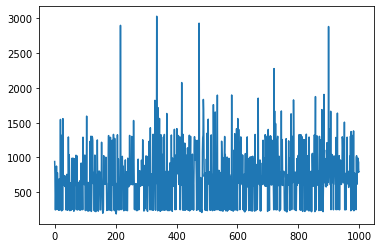

In [ ]:
plt.plot(sum_rewards)
plt.show()

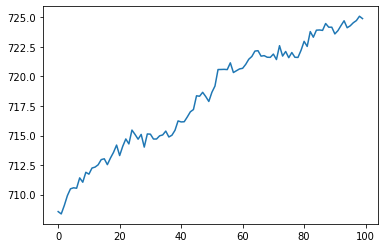

In [ ]:
window_size = 900
plt.plot([np.mean(sum_rewards[i-window_size:i]) for i in range(len(sum_rewards)) if i >= window_size])
plt.show()

# Test

In [ ]:
tmax = 2000
previous_frames = deque(maxlen=MAX_FRAMES)

obs = env.reset()
prev_obs = None
sum_reward = 0

frames = np.zeros((tmax, 240, 256, 3), dtype=np.uint8)
for i in range(MAX_FRAMES):
  previous_frames.append(np.zeros(FRAME_SHAPE))
previous_frames.append(np.copy(preprocess(obs)))
states = np.array(previous_frames)
rs = []
xs = []
ys = []

done = False
for t in range(tmax):
  frames[t] = obs
  actions = agent.act(states, noise)
  obs, reward, done, info = env.step(actions)
  previous_frames.append(np.copy(preprocess(obs)))
  next_states = np.array(previous_frames)

  sum_reward += reward
  states = next_states
  
  rs.append(reward)
  xs.append(info['x_pos'])
  ys.append(info['y_pos'])
  if done:
    break

In [ ]:
print('Sum of rewards is ', sum(rs))
plt.plot([sum(rs[:i]) for i in range(len(rs))])
plt.show()

plt.plot(xs)
plt.show()

In [ ]:
anim = display_frames(frames[:1000])

In [ ]:
with open('test_reward.txt', 'w') as f:
  for r in rs:
    f.write(str(r))
    f.write('\n')

In [ ]:
anim

## Save the gif and last several frames

In [ ]:
from matplotlib.animation import PillowWriter

writer = PillowWriter(fps=50)  
anim.save("animation.gif", writer=writer)

In [ ]:
batch_tensor = torch.from_numpy(frames[800:864]).view(-1,3,240,256)

In [ ]:
grid_img = vutils.make_grid(batch_tensor, nrow=8)
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Agent Actions")
plt.imshow(np.transpose(grid_img.cpu(), (1, 2, 0)))

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
          nrows_ncols=(8, 8),  # creates 2x2 grid of axes
          axes_pad=0.1,  # pad between axes in inch.
          )

for ax, im in zip(grid, frames[888:952]):
  # Iterating over the grid returns the Axes.
  ax.imshow(im)

plt.show()